# 데이터 불러오기

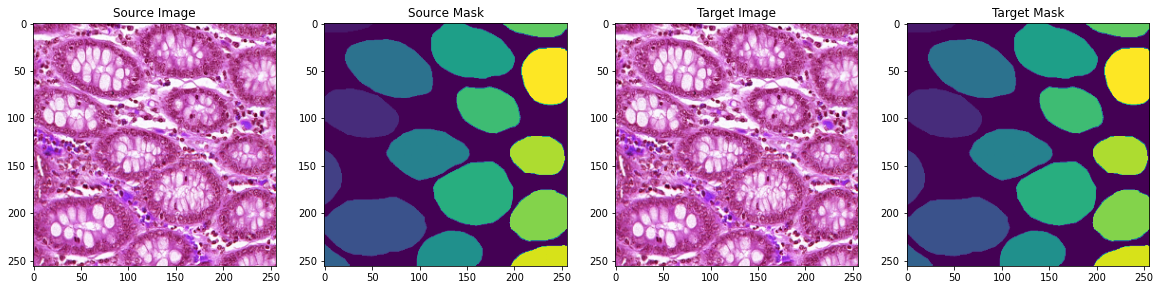

In [175]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random


imsize = 256
source = 12
target = 12

image_source = cv2.imread(f'./data/Warwick QU Dataset (Released 2016_07_08)/train_{source}.bmp', cv2.IMREAD_COLOR)
mask_source = cv2.imread(f'./data/Warwick QU Dataset (Released 2016_07_08)/train_{source}_anno.bmp', cv2.IMREAD_GRAYSCALE)

image_target = cv2.imread(f'./data/Warwick QU Dataset (Released 2016_07_08)/train_{target}.bmp', cv2.IMREAD_COLOR)
mask_target= cv2.imread(f'./data/Warwick QU Dataset (Released 2016_07_08)/train_{target}_anno.bmp', cv2.IMREAD_GRAYSCALE)

image_source = cv2.resize(image_source, (imsize,imsize))
mask_source = cv2.resize(mask_source, (imsize,imsize))

image_target = cv2.resize(image_target, (imsize,imsize))
mask_target = cv2.resize(mask_target, (imsize,imsize))

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(image_source)
plt.title('Source Image')

plt.subplot(1,4,2)
plt.imshow(mask_source)
plt.title('Source Mask')

plt.subplot(1,4,3)
plt.imshow(image_target)
plt.title('Target Image')

plt.subplot(1,4,4)
plt.imshow(mask_target)
plt.title('Target Mask')

plt.show()

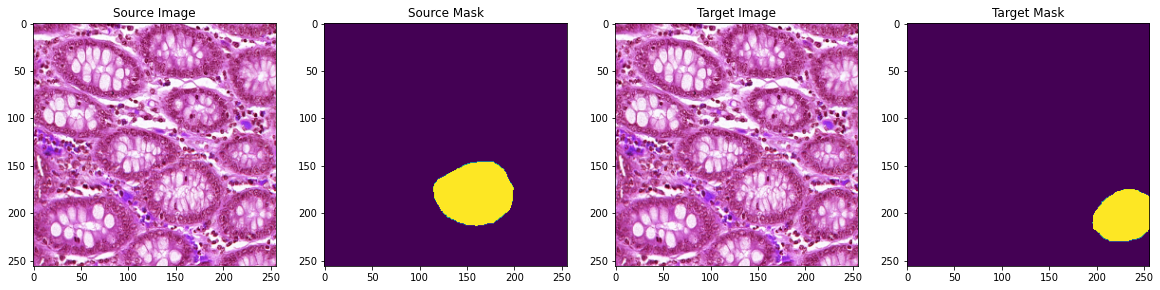

In [177]:
from skimage import measure

mask_source = np.where(mask_source>=1.0, 1.0, 0.0)
mask_target = np.where(mask_target>=1.0, 1.0, 0.0)
mask_source = measure.label(mask_source, connectivity=2)
mask_target = measure.label(mask_target, connectivity=2)

object_source_idx = random.choice(np.unique(mask_source)[1:]) # 0번은 배경을 선택해버린다
object_target_idx = random.choice(np.unique(mask_target)[1:]) # 0번은 배경을 선택해버린다

selected_source = np.where((mask_source==object_source_idx)>=1.0,1.0,0)
selected_target = np.where((mask_target==object_target_idx)>=1.0,1.0,0)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(image_source)
plt.title('Source Image')

plt.subplot(1,4,2)
plt.imshow(selected_source)
plt.title('Source Mask')

plt.subplot(1,4,3)
plt.imshow(image_target)
plt.title('Target Image')

plt.subplot(1,4,4)
plt.imshow(selected_target)
plt.title('Target Mask')

plt.show()

# 라플라시안 필터(edge 검출)

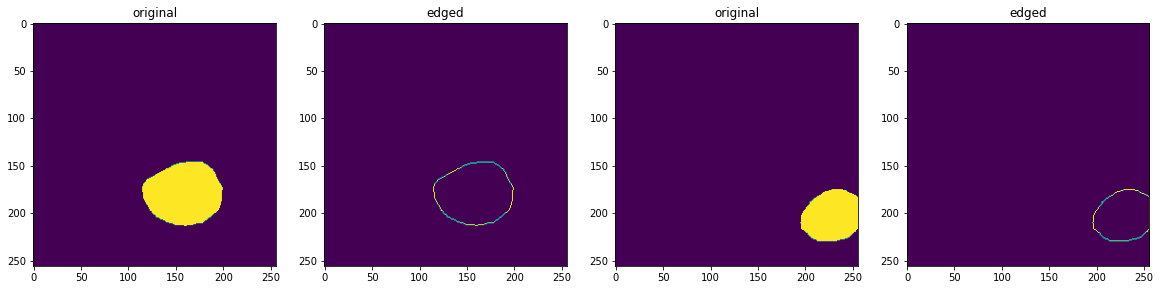

In [178]:
selected_source_boundary = np.zeros((imsize,imsize))
selected_source_boundary[0,0:] = selected_source[0,0:]
selected_source_boundary[-1,0:] = selected_source[-1,0:]
selected_source_boundary[0:,0] = selected_source[0:,0]
selected_source_boundary[0:,-1] = selected_source[0:,-1]

selected_target_boundary = np.zeros((imsize,imsize))
selected_target_boundary[0,0:] = selected_target[0,0:]
selected_target_boundary[-1,0:] = selected_target[-1,0:]
selected_target_boundary[0:,0] = selected_target[0:,0]
selected_target_boundary[0:,-1] = selected_target[0:,-1]


pad_size = 1
laplacianFilter = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
selected_source_edge = np.where(cv2.filter2D(np.pad(selected_source,(pad_size,pad_size),mode='constant'),-1,laplacianFilter)[pad_size:-pad_size,pad_size:-pad_size]>0,1.0,0)
selected_target_edge = np.where(cv2.filter2D(np.pad(selected_target,(pad_size,pad_size),mode='constant'),-1,laplacianFilter)[pad_size:-pad_size,pad_size:-pad_size]>0,1.0,0)

plt.figure(figsize=(20,40))
plt.subplot(1,4,1)
plt.imshow(selected_source)
plt.title('original')

plt.subplot(1,4,2)
plt.imshow(selected_source_edge)
plt.title('edged')

plt.subplot(1,4,3)
plt.imshow(selected_target)
plt.title('original')

plt.subplot(1,4,4)
plt.imshow(selected_target_edge)
plt.title('edged')
plt.show()

# edge pruning

source edge : 218.0 -> 218.0
target edge : 172.0 -> 172.0


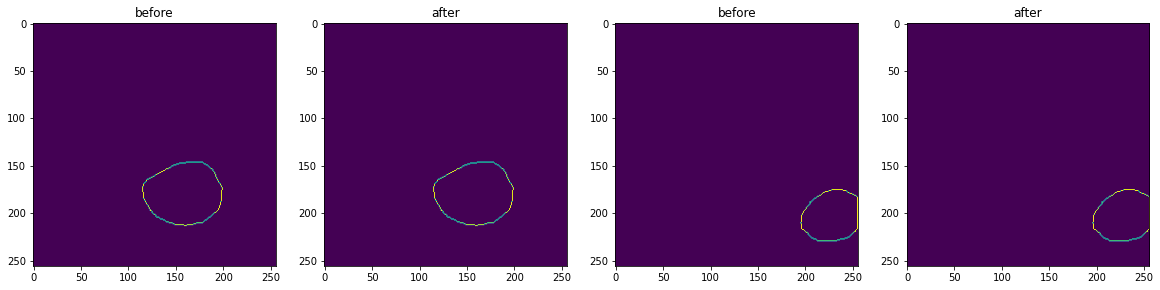

In [179]:
import copy

def prune_edge(edge):
    '''
    Isolated edge를 prune 해주는 함수
    = input =
    edge : unpruned np.array (h,w) shape. Edge만 가진 mask이다.
    = output =
    pruned_edge : pruned np.array (h,w) shape
    '''
    neighbor_filter = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    pruned_edge = copy.deepcopy(edge)
    while True:
        sum_edge = np.sum(pruned_edge)
        pruned_edge -= np.where(cv2.filter2D(pruned_edge,-1,neighbor_filter)==-7.0, 1.0, 0)
        if np.sum(pruned_edge) == sum_edge:
            break
    return pruned_edge


pruned_source_edge = prune_edge(selected_source_edge)
pruned_target_edge = prune_edge(selected_target_edge)

print(f'source edge : {np.sum(selected_source_edge)} -> {np.sum(pruned_source_edge)}')
print(f'target edge : {np.sum(selected_target_edge)} -> {np.sum(pruned_target_edge)}')


plt.figure(figsize=(20,40))
plt.subplot(1,4,1)
plt.imshow(selected_source_edge)
plt.title('before')

plt.subplot(1,4,2)
plt.imshow(pruned_source_edge)
plt.title('after')

plt.subplot(1,4,3)
plt.imshow(selected_target_edge)
plt.title('before')

plt.subplot(1,4,4)
plt.imshow(pruned_target_edge)
plt.title('after')
plt.show()

# 무어 알고리즘(edge flatten)

In [180]:
from scipy.ndimage import label


def get_coordinate(h,w):
    '''
    (h,w,2) shape의 np.array를 출력
    [h,w]의 성분인 2개의 채널은 
    0번 채널에 h의 coordinate
    1번 채널에 w의 coordinate를 포함
    '''
    coordinate = []
    h_coordinate = []
    w_coordinate = []
    for i in range(h):
        h_coordinate.append([i for _ in range(w)])
    for i in range(w):
        w_coordinate.append([i for _ in range(h)])
    h_coordinate = np.array(h_coordinate)
    w_coordinate = np.array(w_coordinate)
    w_coordinate = w_coordinate.T
    coordinate = np.stack([h_coordinate, w_coordinate], -1)
    return coordinate


def find_nth_smallest(arr, n):
    return int(np.sort(np.unique(arr.flatten()))[n])


def is_in(arr,target):    
    return np.any(np.all(arr == target, axis=-1))


def moore_algorithm(mask):
    '''
    mask : edged mask
    '''
    assert len(mask.shape)==2
    labeled_array, num_features = label(mask, structure=np.ones((3, 3)))
    edge_list = []

    for i in range(1,num_features+1):
        mask = np.where(labeled_array==i, 1, 0)
        edge_list += _moore_algorithm(mask)

    edge_list = np.array(edge_list) - 1
    return edge_list


def _moore_algorithm(mask):
    '''
    mask : edged mask
    '''
    assert len(mask.shape)==2
    h, w = mask.shape
    coordinate = get_coordinate(h,w)
    coordinate += 1
    coordinate_edge = coordinate * mask[...,None]
    h_start = find_nth_smallest(coordinate_edge[...,0],-1) # 가장 아래
    w_start = find_nth_smallest(coordinate_edge[coordinate_edge[...,0]==h_start][...,1],0) # 가장 왼쪽
    mask = np.pad(mask,(1,1))
    
    edge_list = [[h_start, w_start]]
    h_now = copy.deepcopy(h_start)
    w_now = copy.deepcopy(w_start)
    stop = True
    while stop:
        # next_steps = [[h_now+1, w_now],
        #               [h_now+1, w_now-1],
        #               [h_now, w_now-1],
        #               [h_now-1, w_now-1],
        #               [h_now-1, w_now],
        #               [h_now-1, w_now+1],
        #               [h_now, w_now+1],
        #               [h_now+1, w_now+1]]
        next_steps = [[h_now, w_now-1],
                      [h_now-1, w_now-1],
                      [h_now-1, w_now],
                      [h_now-1, w_now+1],
                      [h_now, w_now+1],
                      [h_now+1, w_now+1],
                      [h_now+1, w_now],
                      [h_now+1, w_now-1]]
        for h_temp, w_temp in next_steps:
            if mask[h_temp,w_temp] == 1.0:
                if [h_temp,w_temp] == [h_start, w_start]:
                    if len(edge_list) > np.sum(mask)-3:
                        stop = False
                        edge_list.append([h_start, w_start])
                        break
                elif [h_temp,w_temp] in edge_list:
                    pass
                else:
                    edge_list.append([h_temp,w_temp])
                    h_now = copy.deepcopy(h_temp)
                    w_now = copy.deepcopy(w_temp)
                    break
        else:
            '''
            뭐던간에 2개 겹친거는 알고리즘을 바보로 만든다.
            '''
            edge_list[-1], edge_list[-2] = edge_list[-2], edge_list[-1]
            h_now, w_now = edge_list[-1]
            # raise NotImplementedError(f'The edge [{h_now-1}, {w_now-1}] seems to be an isolated.')

        if len(edge_list) == np.sum(mask):
            stop = False
            edge_list.append([h_start, w_start])
        
    return edge_list


if __name__ == '__main__':
    coordinate = get_coordinate(imsize,imsize)
    coordinate_source = coordinate * selected_source[...,None] # (imsize,imsize,2)
    coordinate_target = coordinate * selected_target[...,None] # (imsize,imsize,2)
    coordinate_source_edge = coordinate * selected_source_edge[...,None] # (imsize,imsize,2)
    coordinate_target_edge = coordinate * selected_target_edge[...,None] # (imsize,imsize,2)

    centroid_source = np.sum(np.sum(coordinate_source, 0),0) / np.sum(selected_source)
    centroid_target = np.sum(np.sum(coordinate_target, 0),0) / np.sum (selected_target)
    centroid_x_source, centroid_y_source = int(centroid_source[0]), int(centroid_source[1])
    centroid_x_target, centroid_y_target = int(centroid_target[0]), int(centroid_target[1])

    flatten_source = moore_algorithm(pruned_source_edge)
    flatten_target = moore_algorithm(pruned_target_edge)

    print(centroid_x_source, centroid_y_source)
    print(centroid_x_target, centroid_y_target)

179 158
203 227


# 무어 알고리즘 잘 되었는지 확인

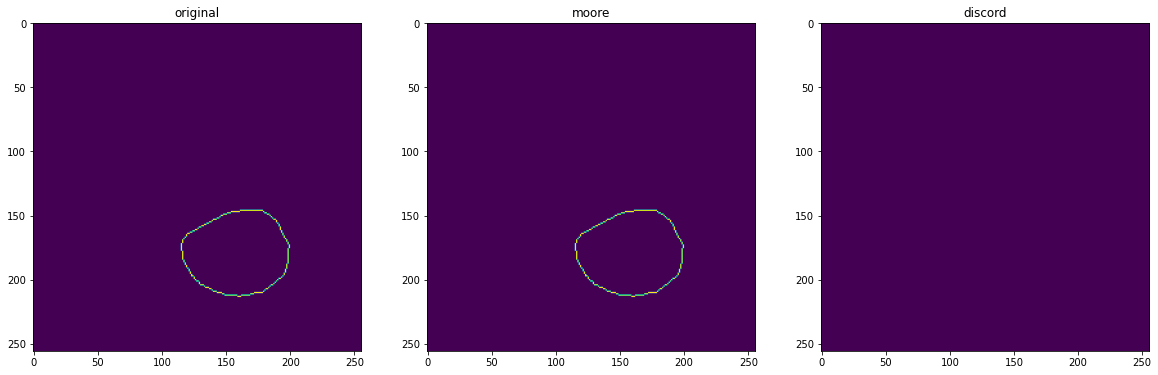

moore algorithm이 성공적으로 edge를 flatten하였습니다.


In [181]:
moore_mask = np.zeros_like(pruned_source_edge)
for x,y in flatten_source:
    moore_mask[x,y] = 1

discord = 1 - (moore_mask == pruned_source_edge)

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(pruned_source_edge)
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(moore_mask)
plt.title('moore')

plt.subplot(1,3,3)
plt.imshow(discord)
plt.title('discord')

plt.show()

if np.sum(discord) == 0:
    print('moore algorithm이 성공적으로 edge를 flatten하였습니다.')
else:
    print('moore algorithm이 edge를 flatten하지 못했습니다.')

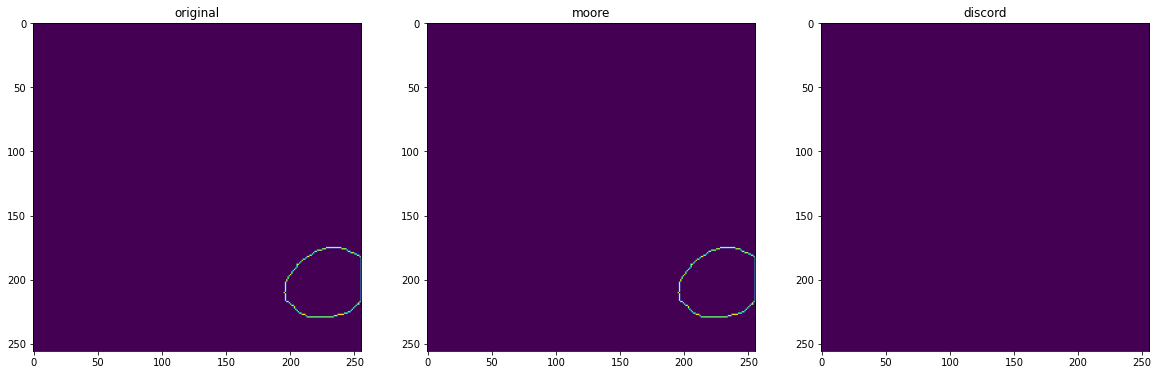

moore algorithm이 성공적으로 edge를 flatten하였습니다.


In [182]:
moore_mask = np.zeros_like(pruned_target_edge)
for x,y in flatten_target:
    moore_mask[x,y] = 1

discord = 1 - (moore_mask == pruned_target_edge)

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(pruned_target_edge)
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(moore_mask)
plt.title('moore')

plt.subplot(1,3,3)
plt.imshow(discord)
plt.title('discord')

plt.show()

if np.sum(discord) == 0:
    print('moore algorithm이 성공적으로 edge를 flatten하였습니다.')
else:
    print('moore algorithm이 edge를 flatten하지 못했습니다.')

# 양파까기

In [183]:
def onion_peeling(selected_object, prune_all=False):
    '''
    = input =
    selected_object : 원하는 객체만 선택된 mask. np.array. (h,w) shape
    prune_all
    = output =
    edges : selected_object의 양파껍질만 모은 것. list에 (h,w) shape의 np.array가 여러개 들어있음.
    onions : 양파껍질을 하나 제거하고 남은 양파 -> 또 제거하고 남은 양파....를 모은 list. (h,w) shape의 양파가 여러개 들어있음.
    '''
    # 초기 선언
    i = 0
    onions = [selected_object]
    edges = []
    pad_size = 1
    laplacianFilter = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

    # edge 검출
    while True:
        i += 1
        
        # edge 검출 및 pruning. 첫 껍질은 무조건 pruning 하겠다.
        if i == 1:
            edge = np.where(cv2.filter2D(np.pad(onions[-1],(pad_size,pad_size),mode='constant'),-1,laplacianFilter)[pad_size:-pad_size,pad_size:-pad_size]>0,1.0,0)
            edge = prune_edge(edge)
            edges.append(edge)
        elif prune_all:
            edge = np.where(cv2.filter2D(np.pad(onions[-1],(pad_size,pad_size),mode='constant'),-1,laplacianFilter)[pad_size:-pad_size,pad_size:-pad_size]>0,1.0,0)
            edge = prune_edge(edge)
            edges.append(edge)
        else:
            edge = np.where(cv2.filter2D(np.pad(onions[-1],(pad_size,pad_size),mode='constant'),-1,laplacianFilter)[pad_size:-pad_size,pad_size:-pad_size]>0,1.0,0)
            edges.append(edge)
        
        # onion 만들기        
        onions.append(onions[-1] - edge)
        if np.sum(onions[-1]) == 0:
            break
    
    return edges, onions

## 양파까기(source)

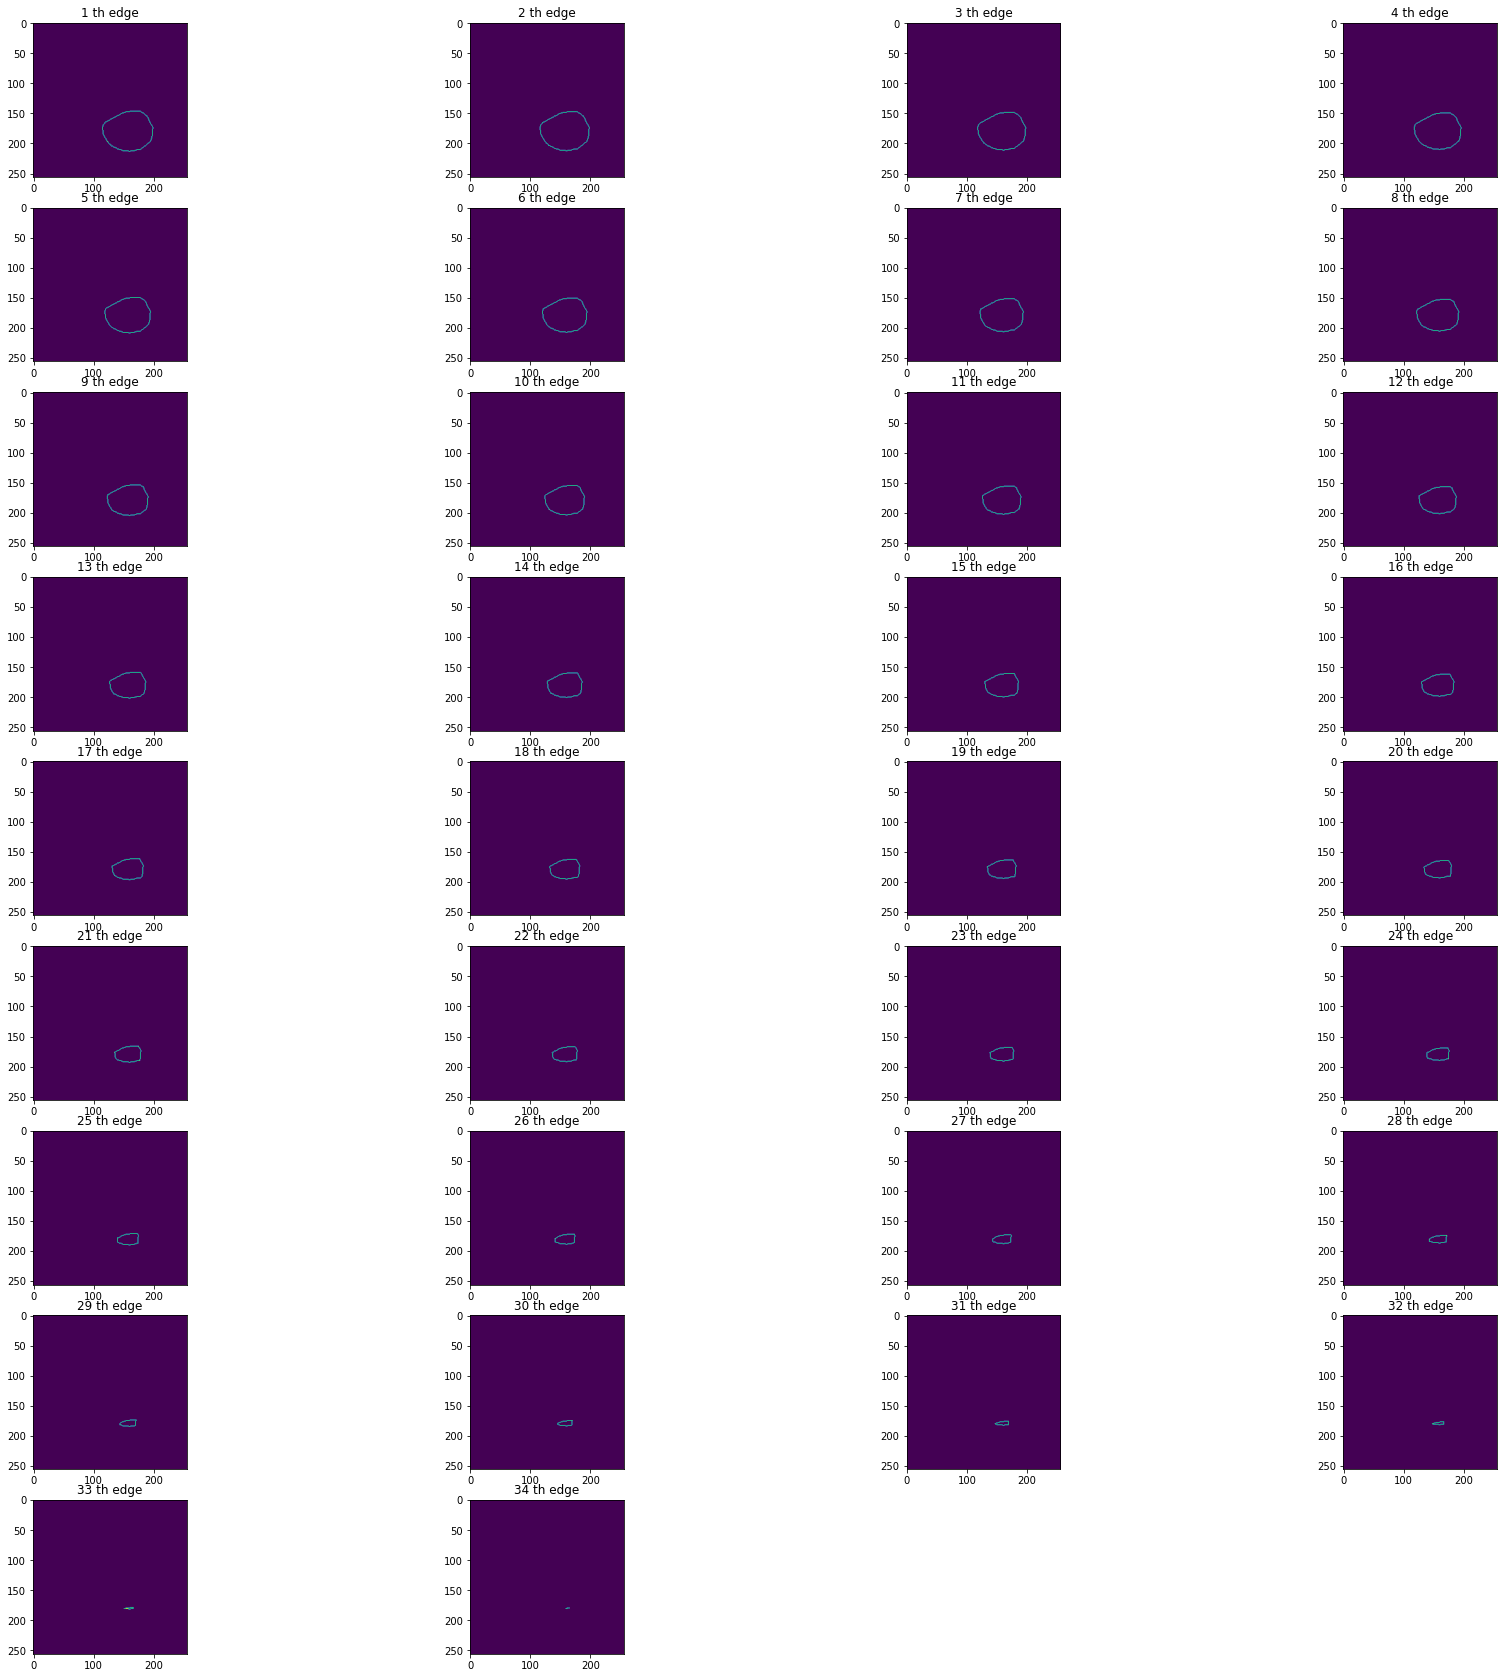

In [184]:
edges_source, _ = onion_peeling(selected_source)
    
i = len(edges_source)
plt.figure(figsize=(30,30))
for idx in range(1,i+1):
    plt.subplot(i//4+1,4,idx)
    plt.imshow(edges_source[idx-1])
    plt.title(f'{idx} th edge')

plt.show()

## 양파 조립하기(source)

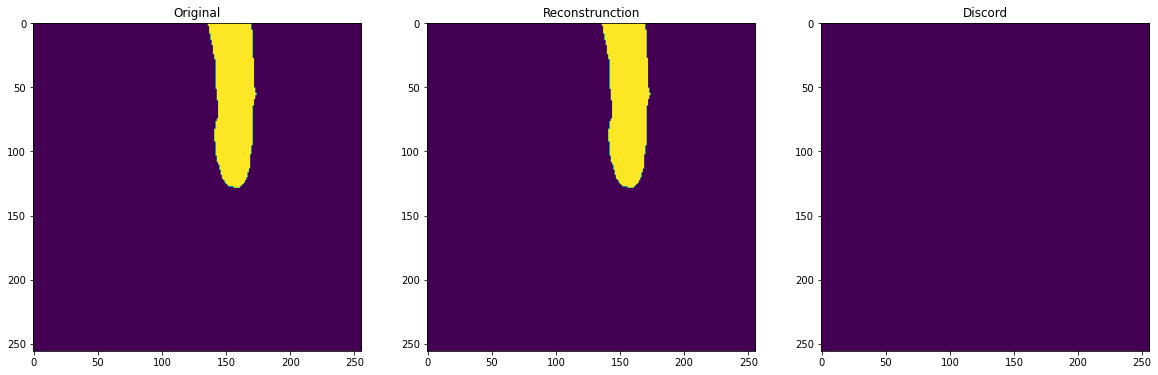

불일치하는 픽셀의 수 : 0.0


In [13]:
reconstruction = np.zeros_like(selected_source)

for edge in edges_source:
    reconstruction += edge

plt.figure(figsize=(20,40))

plt.subplot(1,3,1)
plt.imshow(selected_source)
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(reconstruction)
plt.title('Reconstrunction')

plt.subplot(1,3,3)
plt.imshow(np.abs(selected_source-reconstruction))
plt.title('Discord')

plt.show()

print(f'불일치하는 픽셀의 수 : {np.sum(np.abs(selected_source-reconstruction))}')

## 이미지로 양파까기(source)

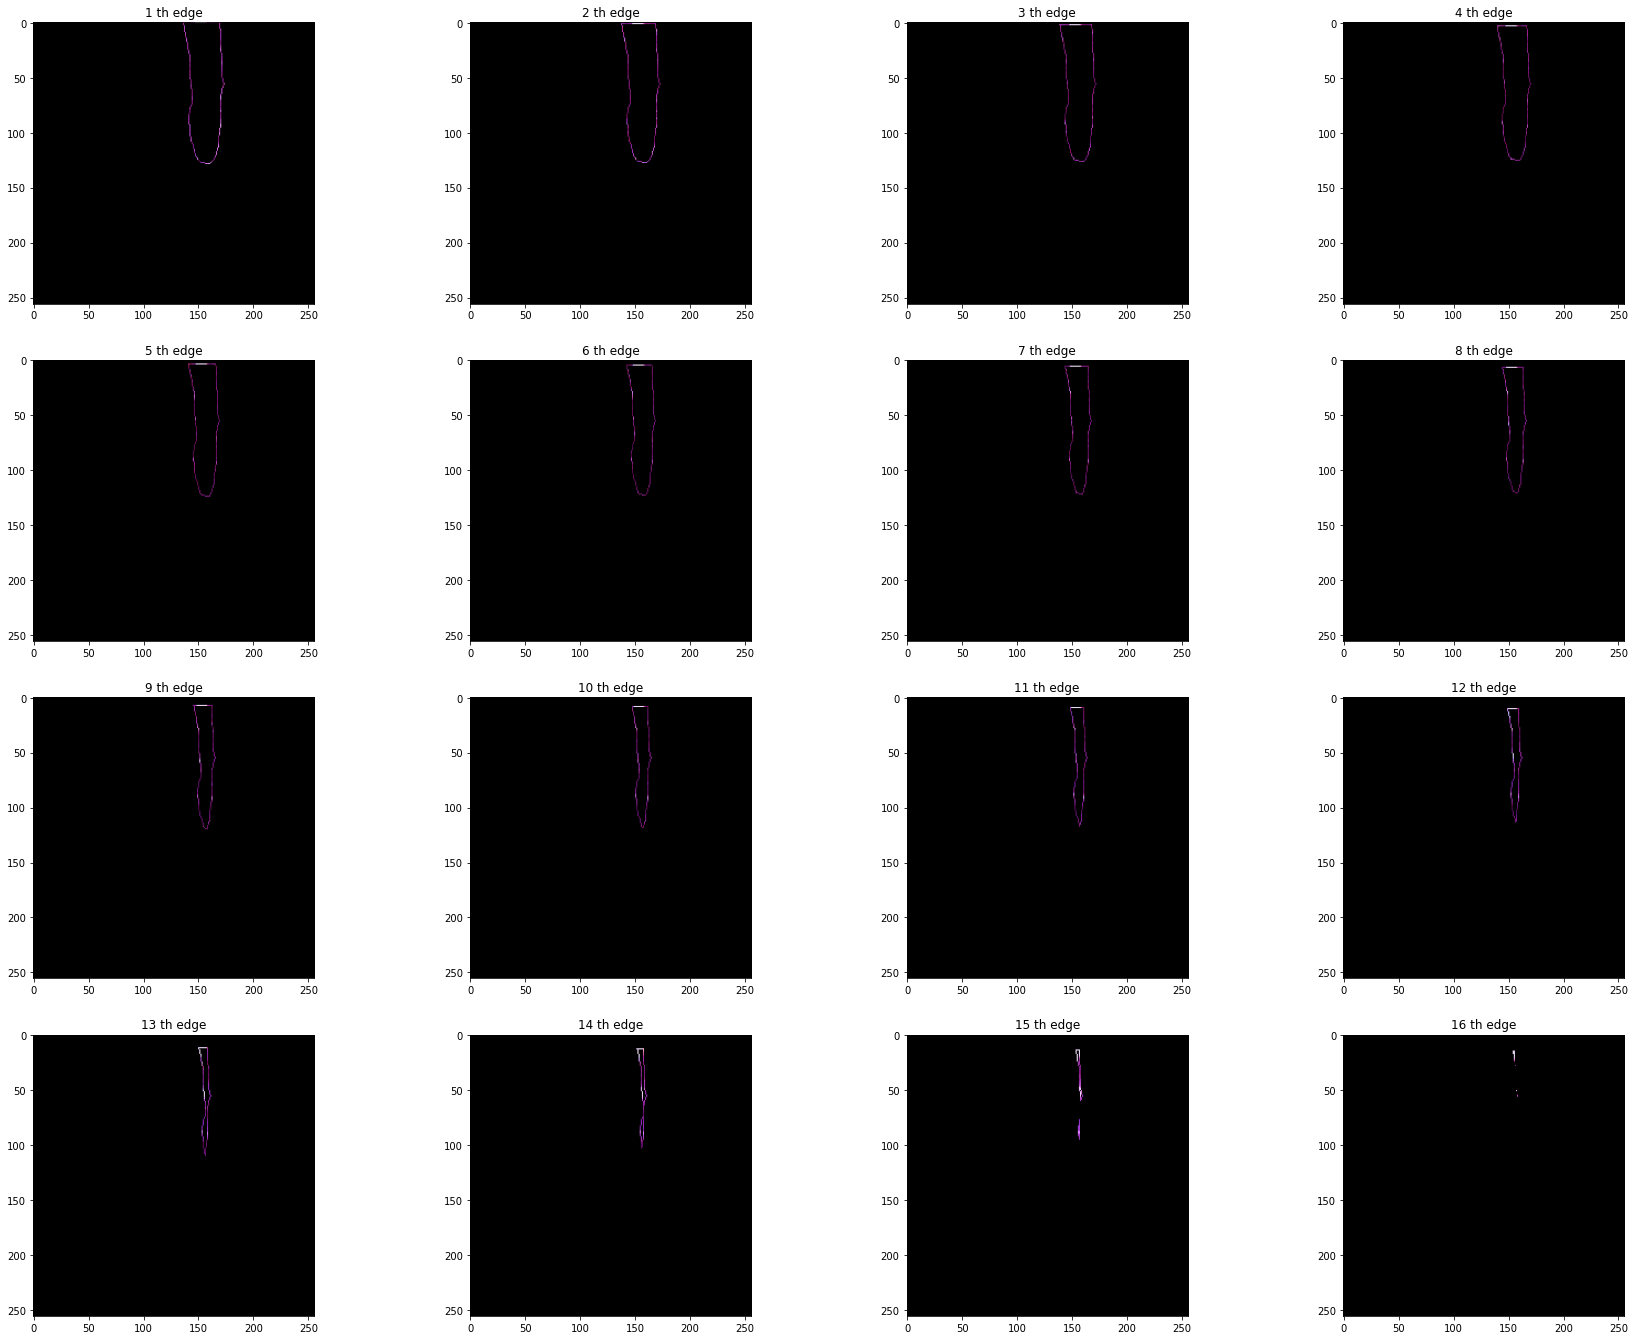

In [14]:
plt.figure(figsize=(30,30))
for idx in range(1,i+1):
    plt.subplot(i//4+1,4,idx)
    plt.imshow((image_source * edges_source[idx-1][...,None]).astype(np.uint8))
    plt.title(f'{idx} th edge')

plt.show()

## 양파까기(target)

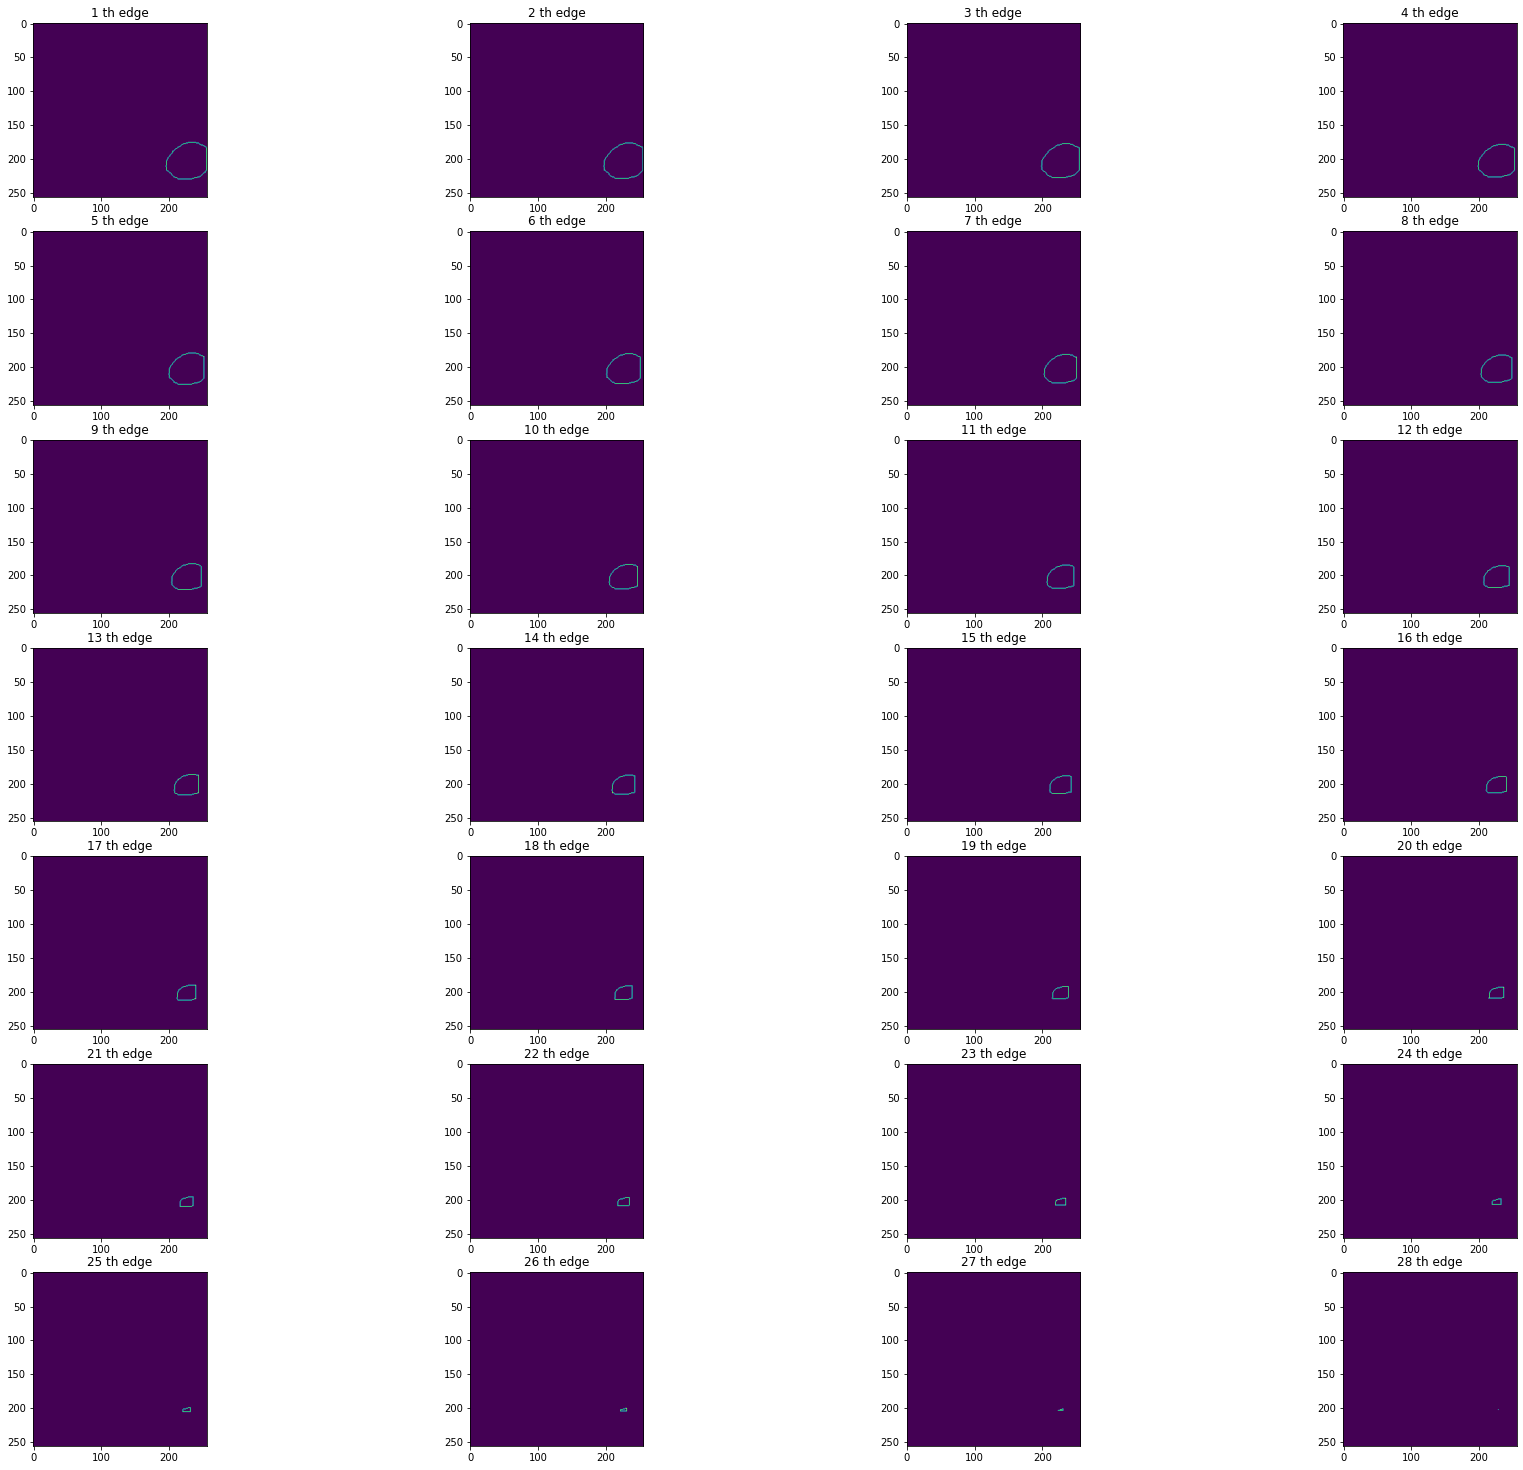

In [185]:
edges_target, _ = onion_peeling(selected_target)

i = len(edges_target)
plt.figure(figsize=(30,30))
for idx in range(1,i+1):
    plt.subplot(i//4+1,4,idx)
    plt.imshow(edges_target[idx-1])
    plt.title(f'{idx} th edge')

plt.show()

## 양파 조립하기(target)

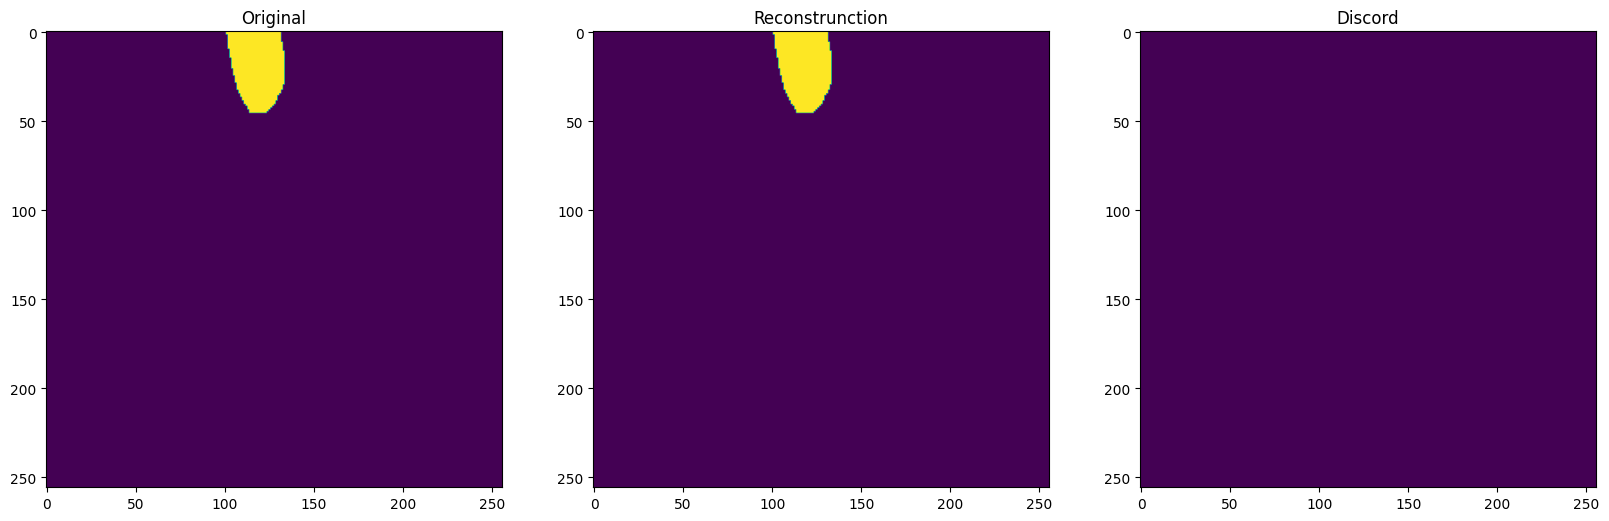

불일치하는 픽셀의 수 : 0.0


In [101]:
reconstruction = np.zeros_like(selected_target)

for idx, edge in enumerate(edges_target):
    reconstruction += edge

plt.figure(figsize=(20,40))

plt.subplot(1,3,1)
plt.imshow(selected_target)
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(reconstruction)
plt.title('Reconstrunction')

plt.subplot(1,3,3)
plt.imshow(np.abs(selected_target-reconstruction))
plt.title('Discord')

plt.show()

print(f'불일치하는 픽셀의 수 : {np.sum(np.abs(selected_target-reconstruction))}')

## 이미지로 양파까기(target)

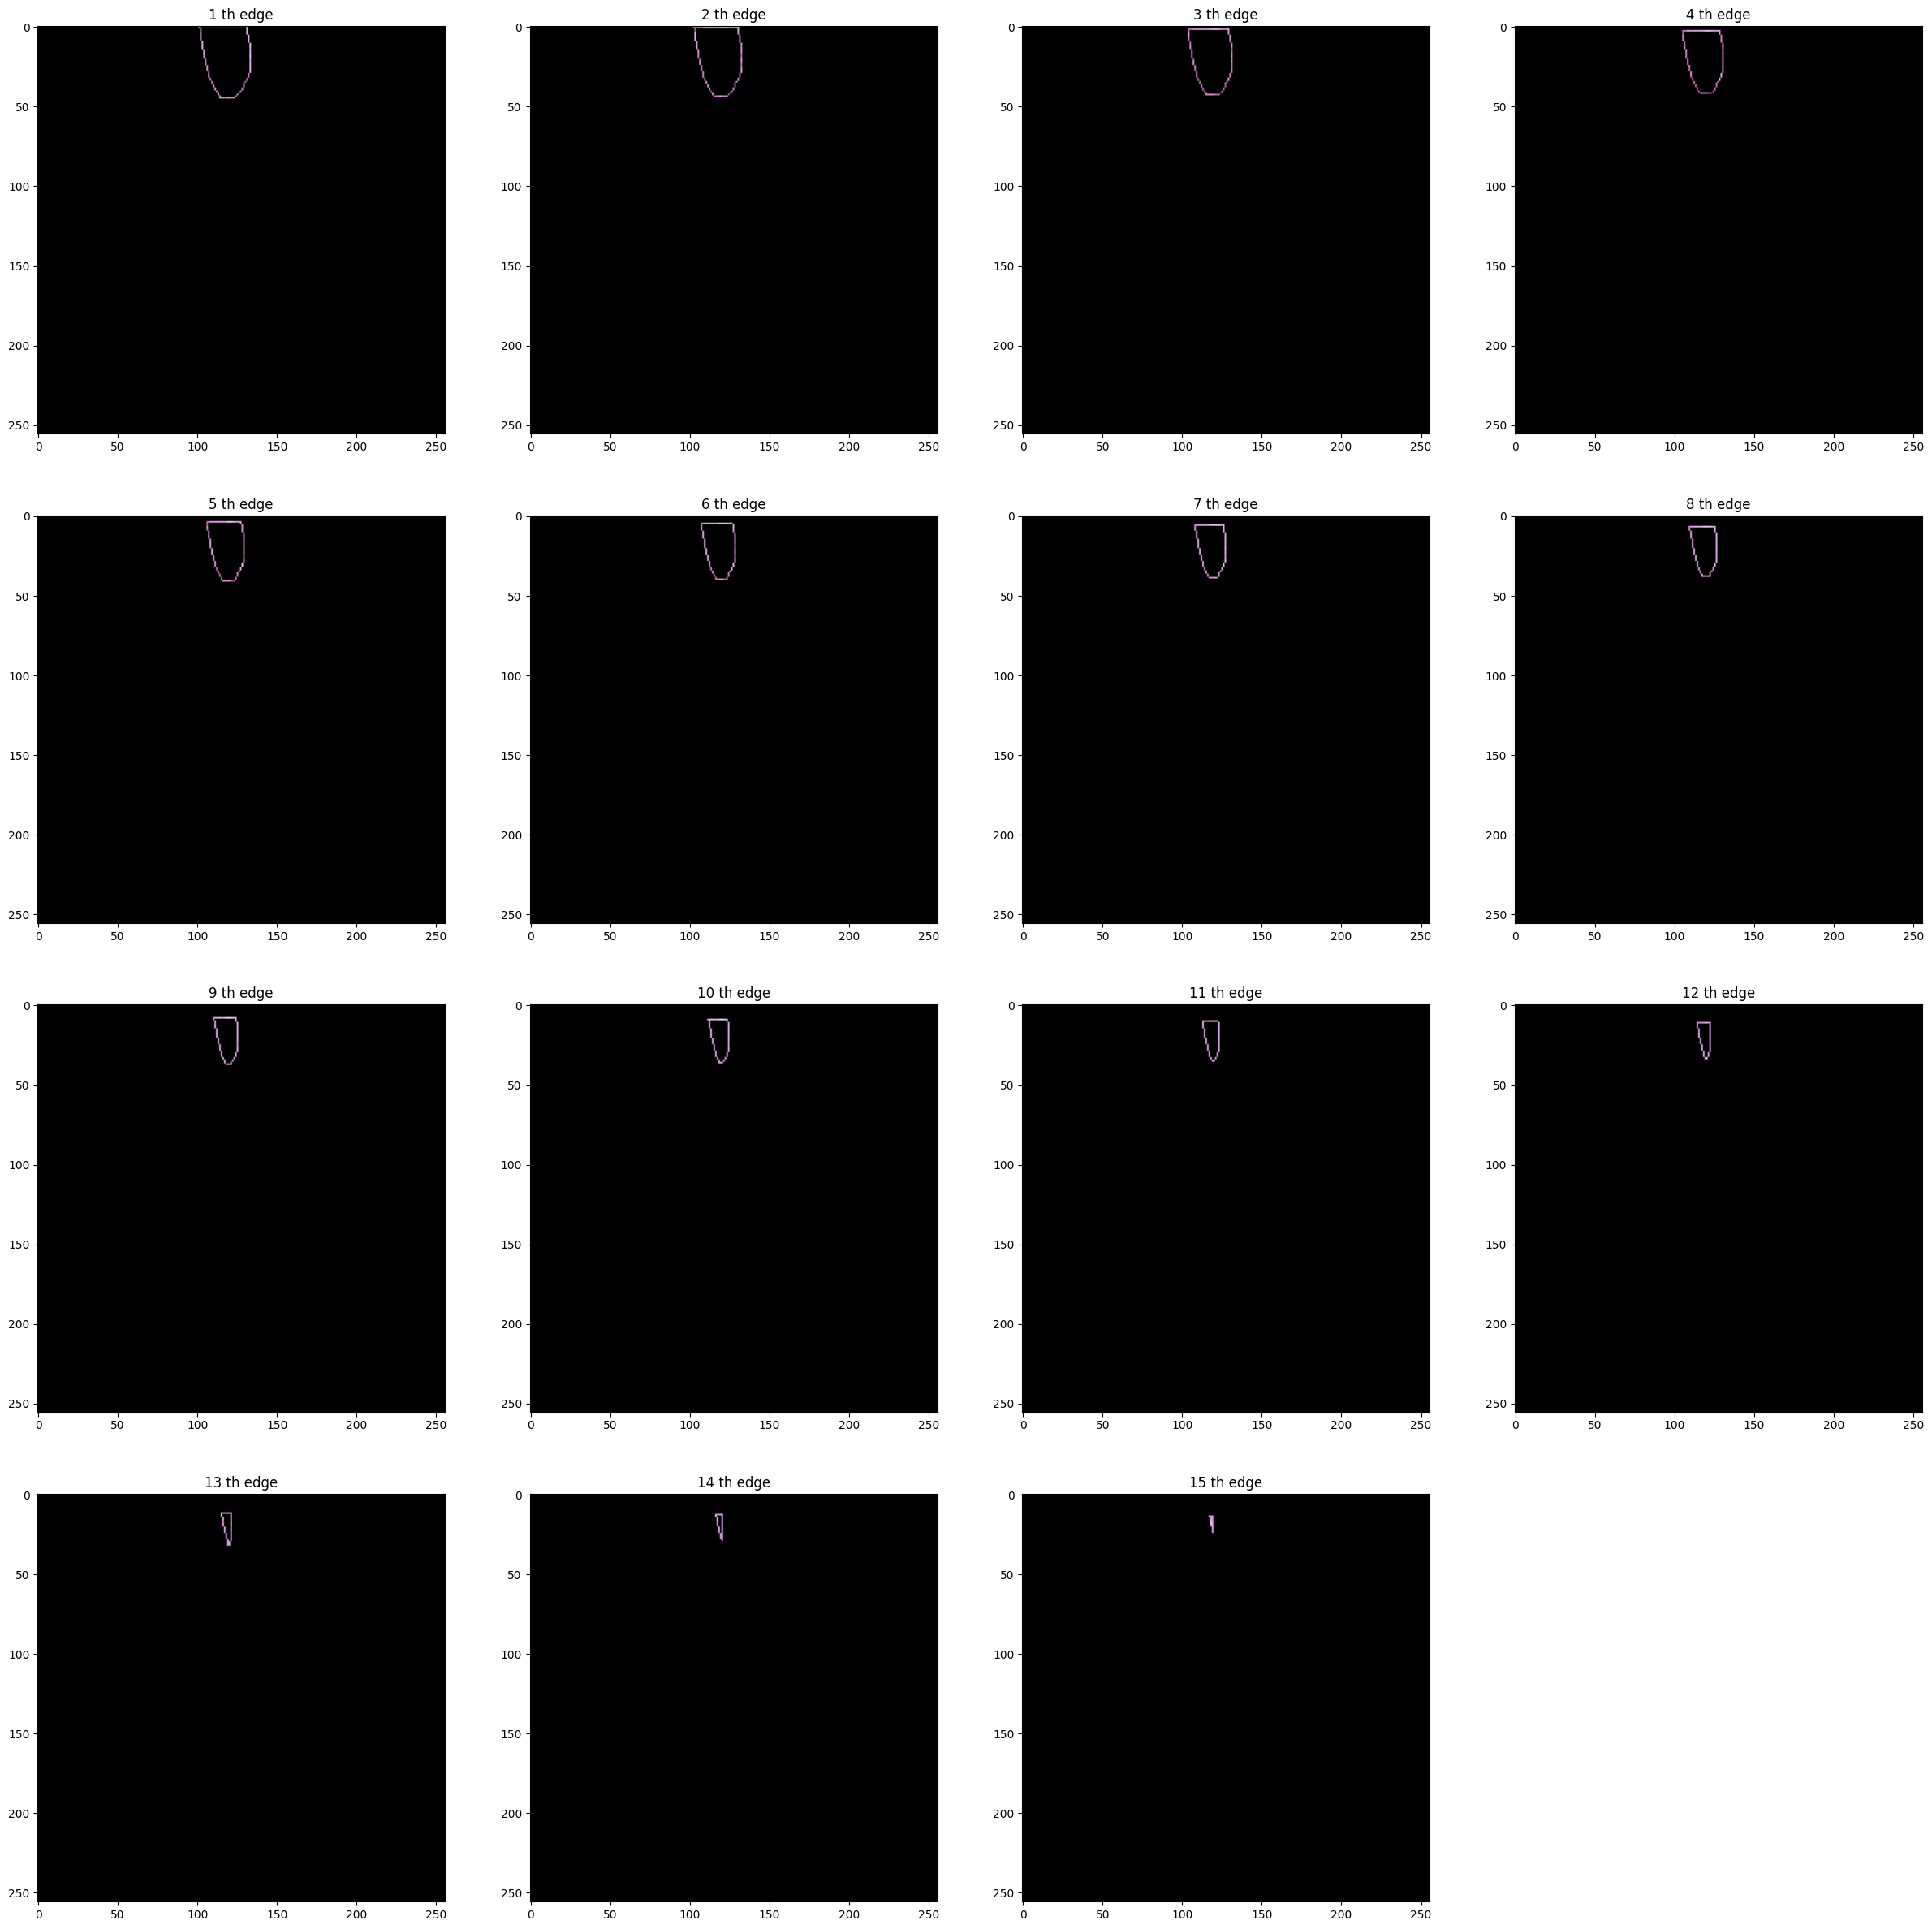

In [102]:
plt.figure(figsize=(30,30))
for idx in range(1,i+1):
    plt.subplot(i//4+1,4,idx)
    plt.imshow((image_target * edges_target[idx-1][...,None]).astype(np.uint8))
    plt.title(f'{idx} th edge')

plt.show()

# 껍질수맞춰주기(Resize)

## resize 후 다시 양파까기

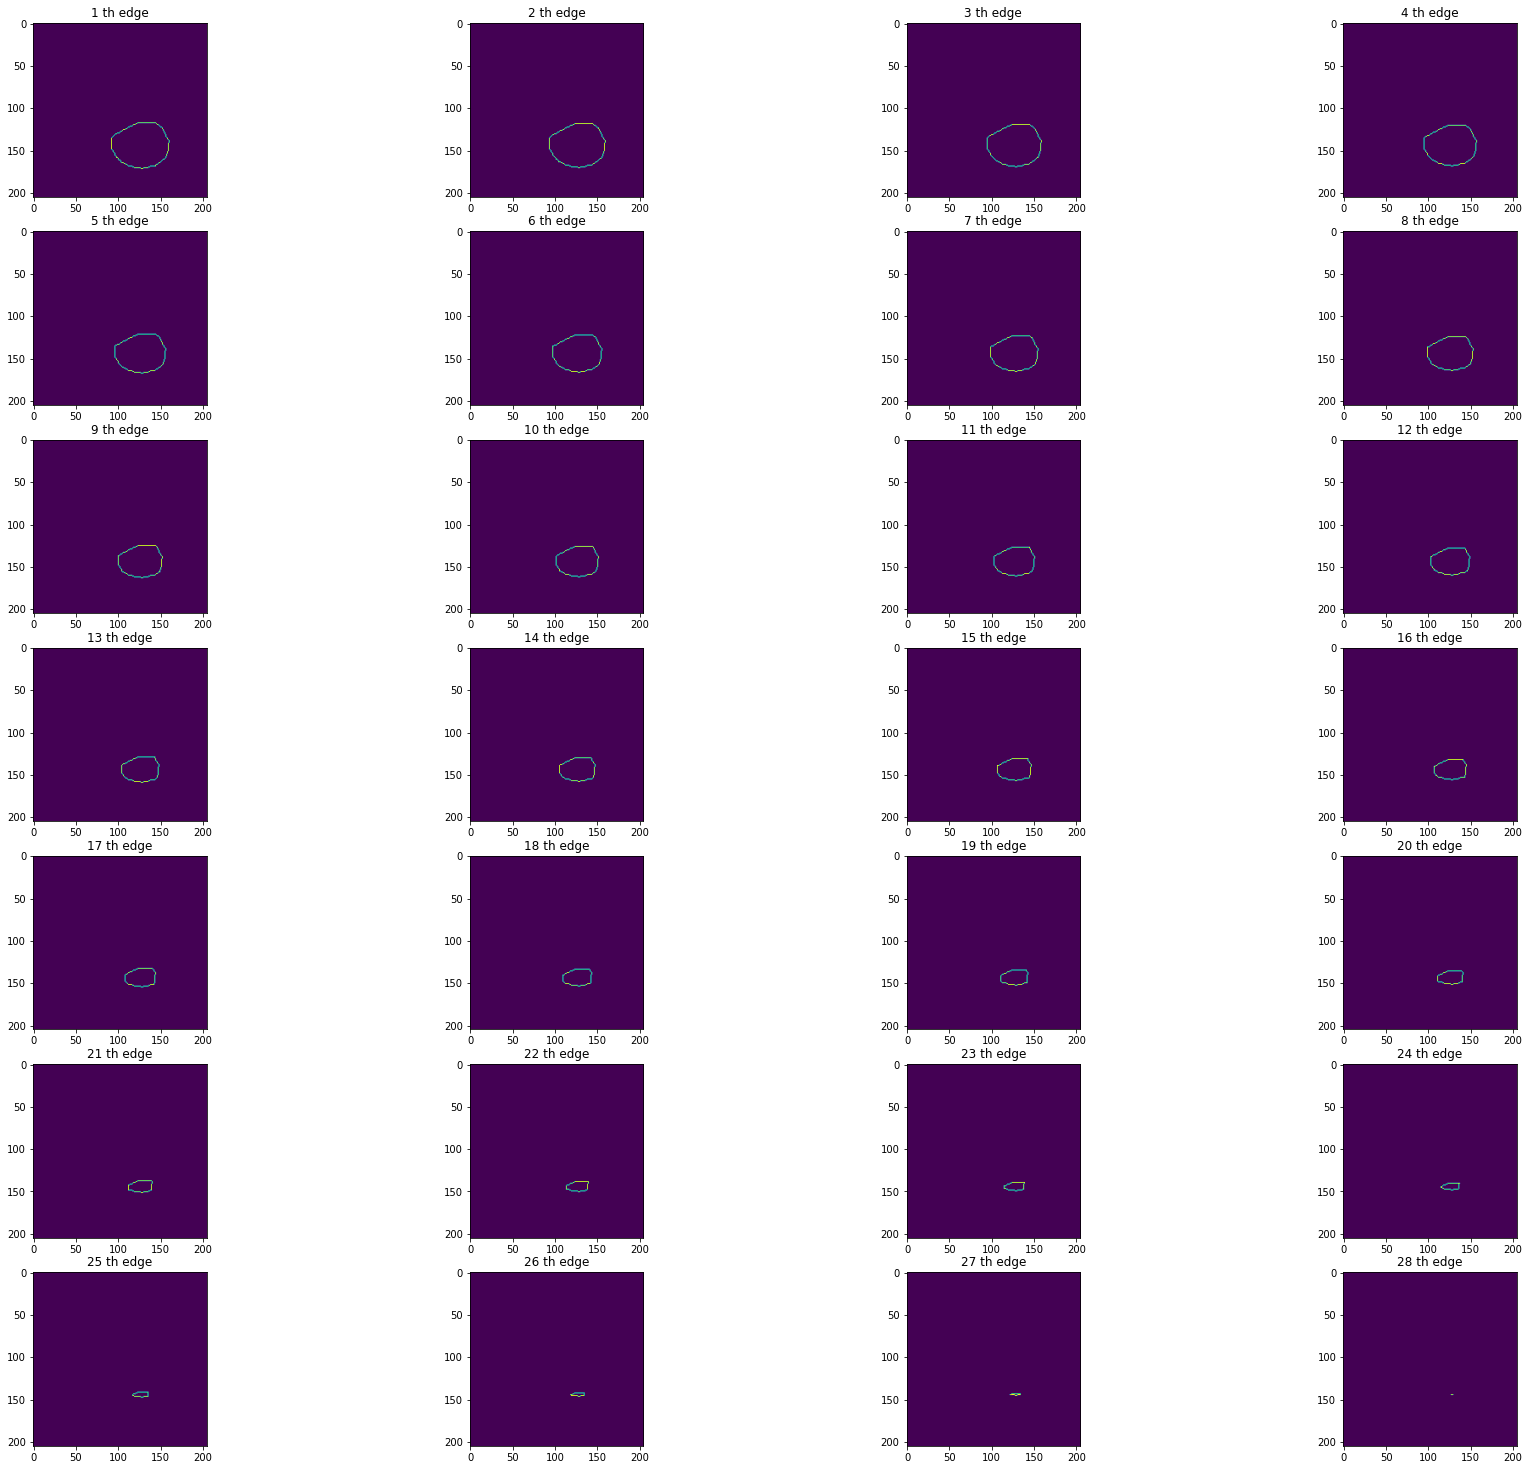

Target의 껍질 수 : 28, Source의 껍질 수 : 28


In [186]:
def resize_and_onion_peeling(edges_source, edges_target, selected_source):
    '''
    '''
    # 비율 정하기
    ratio = len(edges_target)/len(edges_source)
    imsize_source = int(imsize * ratio)

    # 이미지 resize
    image_source_resized = cv2.resize(image_source, (imsize_source, imsize_source))
    mask_source_resized = cv2.resize(mask_source.astype(np.float32), (imsize_source, imsize_source))
    selected_source_resized = cv2.resize(selected_source.astype(np.float32), (imsize_source, imsize_source))
    selected_source_resized = np.where(selected_source_resized>0,1.0,0)

    # onion peeling
    while True:
        edges_source_resized, onions_source_resized = onion_peeling(selected_source_resized)
        if len(edges_source_resized) == len(edges_target):
            break
        elif len(edges_source_resized) > len(edges_target):
            imsize_source -= 5
            image_source_resized = cv2.resize(image_source, (imsize_source, imsize_source))
            selected_source_resized = cv2.resize(selected_source.astype(np.float32), (imsize_source, imsize_source))
            selected_source_resized = np.where(selected_source_resized>0,1.0,0)
        else:
            imsize_source += 5
            image_source_resized = cv2.resize(image_source, (imsize_source, imsize_source))
            selected_source_resized = cv2.resize(selected_source.astype(np.float32), (imsize_source, imsize_source))
            selected_source_resized = np.where(selected_source_resized>0,1.0,0)
    
    return image_source_resized, selected_source_resized, edges_source_resized, onions_source_resized, imsize_source



if __name__ == '__main__':
    image_source_resized, selected_source_resized, edges_source_resized, onions_source_resized, imsize_source = resize_and_onion_peeling(edges_source, edges_target, selected_source)

    i = len(edges_source_resized)
    plt.figure(figsize=(30,30))
    for idx in range(1,i+1):
        plt.subplot(i//4+1,4,idx)
        plt.imshow(edges_source_resized[idx-1])
        plt.title(f'{idx} th edge')

    plt.show()


    print(f'Target의 껍질 수 : {len(edges_target)}, Source의 껍질 수 : {len(edges_source_resized)}')

## resize 후 여러 값들 다시

In [187]:
coordinate = get_coordinate(imsize_source,imsize_source)
coordinate_source_resized = coordinate * selected_source_resized[...,None] # (imsize_source,imsize_source,2)
coordinate_source_edge_resized = coordinate * edges_source_resized[0][...,None] # (imsize,imsize,2)


centroid_source_resized = np.sum(np.sum(coordinate_source_resized, 0),0) / np.sum(selected_source_resized)
centroid_x_source_resized, centroid_y_source_resized = int(centroid_source_resized[0]), int(centroid_source_resized[1])

flatten_source_resized = moore_algorithm(edges_source_resized[0])

print(centroid_x_source_resized, centroid_y_source_resized)
print(len(flatten_target), len(flatten_source_resized))

143 126
173 180


# 첫 껍질 : DTW

In [203]:
import math

def dtw(coor_a, coor_b, constraints=True, pre_matching=None):
    '''
    = input = 
    coor_a & coor_b : flatten된 edge coordinates. np.array. (n, 2) shape.
                      coor_a는 source, coor_b는 target을 넣는 것을 추천.
    constraints : 두 시퀀스 중 더 긴 쪽은 중복해서 매칭이 불가능하다(True)
    pre_matching : 몇개의 점을 미리 매칭해둘건지

    = output =
    warping_path : 최소 cost 경로 idx. np.array. (n, 2) shape이다.
                   [1, 4]라는 성분이 있다면 coor_a의 1번 idx는 coor_b의 4번 idx와 매칭되어야한다는 의미다.
    cost_matrix : 두 시퀀스의 경로 누적 cost를 저장한 matrix. np.array. (n,m) shape
    self_cost_matrix : 두 시퀀스의 cost matrix. np.array. (n,m) shape
    '''
    if pre_matching != None:
        assert pre_matching > 1
        assert type(pre_matching) == int
        w_a = int((np.min(coor_a[:,1])+np.max(coor_a[:,1]))/2)
        w_b = int((np.min(coor_b[:,1])+np.max(coor_b[:,1]))/2)
        indices_a = np.where(coor_a[:, 1] == w_a)[0][0]
        indices_b = np.where(coor_b[:, 1] == w_b)[0][0]
        _coor_a = np.concatenate((coor_a[indices_a:], coor_a[:indices_a]))
        _coor_b = np.concatenate((coor_b[indices_b:], coor_b[:indices_b]))
        length_a = int(len(coor_a)/pre_matching)
        length_b = int(len(coor_b)/pre_matching)

        warping_idx = []
        for i in range(pre_matching):
            if i+1 == pre_matching:
                temp_a = _coor_a[i*length_a:]
                temp_b = _coor_b[i*length_b:]
            else:
                temp_a = _coor_a[i*length_a:(i+1)*length_a+1]
                temp_b = _coor_b[i*length_b:(i+1)*length_b+1]
            idx, _, _ = dtw(temp_a, temp_b, constraints=constraints, pre_matching=None)

            if i+1 != pre_matching:
                idx = idx[0:-1]
            
            for j in range(len(idx)):
                idx[j,0] += i*length_a + indices_a if idx[j,0] + i*length_a + indices_a < len(coor_a) else (i*length_a + indices_a) - len(coor_a)
                idx[j,1] += i*length_b + indices_b if idx[j,1] + i*length_b + indices_b < len(coor_b) else (i*length_b + indices_b) - len(coor_b)
            
            idx = idx.tolist()
            warping_idx += idx

        return np.array(warping_idx), _, _
    
    else:
        n = max(len(coor_a), len(coor_b))
        m = min(len(coor_a), len(coor_b))
        constraints = False if n==m else constraints
        cost_matrix = np.zeros((n,m))
        self_cost_matrix = np.zeros((n,m))
        warping_idx = []

        # self cost matrix
        if len(coor_a) >= len(coor_b):
            for i in range(n):
                for j in range(m):
                    self_cost_matrix[i,j] = round(math.sqrt((coor_a[i][0] - coor_b[j][0])**2 +
                                                            (coor_a[i][1] - coor_b[j][1])**2),
                                                3)
        else:
            for i in range(n):
                for j in range(m):
                    self_cost_matrix[i,j] = round(math.sqrt((coor_b[i][0] - coor_a[j][0])**2 +
                                                            (coor_b[i][1] - coor_a[j][1])**2),
                                                3)
        
        # relative cost matrix
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    minimum = 0
                elif i == 0:
                    minimum = cost_matrix[i,j-1]
                elif j == 0:
                    minimum = cost_matrix[i-1,j]
                else:
                    minimum = min(cost_matrix[i,j-1], cost_matrix[i-1,j-1], cost_matrix[i-1,j])
                cost_matrix[i,j] = self_cost_matrix[i,j] + minimum

        # dtw
        ## init
        i, j = 0, 0
        warping_idx.append([0,0])
        
        ## to prevent out of idx Error
        temp_cost_matrix = np.full((n+1,m+1), math.inf)
        temp_cost_matrix[0:n, 0:m] = cost_matrix

        ## if constrains, define possible movements
        num_down_dir = n - m

        while True:
            if constraints:
                down = temp_cost_matrix[i+1,j]
                diag = temp_cost_matrix[i+1,j+1]
                if down < diag and num_down_dir>0:
                    warping_idx.append([i+1,j])
                    i += 1
                    num_down_dir -= 1
                else:
                    warping_idx.append([i+1,j+1])
                    i += 1
                    j += 1
            else: 
                down = temp_cost_matrix[i+1,j]
                diag = temp_cost_matrix[i+1,j+1]
                right = temp_cost_matrix[i,j+1]
                minimum = min(down, diag, right)
                if minimum == down:
                    warping_idx.append([i+1, j])
                    i += 1
                elif minimum == diag:
                    warping_idx.append([i+1,j+1])
                    i += 1
                    j += 1
                elif minimum == right:
                    warping_idx.append([i, j+1])
                    j += 1

            
            if i==n-1 and j==m-1:
                break
        
        warping_idx = np.array(warping_idx)
        if len(coor_a) < len(coor_b):
            warping_idx = np.concatenate([warping_idx[...,1][...,None], warping_idx[...,0][...,None]], axis=-1)

        return warping_idx, cost_matrix, self_cost_matrix


if __name__ == '__main__':
    centroid_moved_flatten_source = copy.deepcopy(flatten_source_resized)
    centroid_moved_flatten_source[...,0] -= centroid_x_source_resized
    centroid_moved_flatten_source[...,1] -= centroid_y_source_resized

    centroid_moved_flatten_target = copy.deepcopy(flatten_target)
    centroid_moved_flatten_target[...,0] -= centroid_x_target
    centroid_moved_flatten_target[...,1] -= centroid_y_target

    warping_idx, cost_matrix, self_cost_matrix = dtw(centroid_moved_flatten_source[0:-1], centroid_moved_flatten_target[0:-1], True, 24)

    print(f'Source edge length : {len(flatten_source_resized)}, Target edge length : {len(flatten_target)}')

Source edge length : 180, Target edge length : 173


## 첫 껍질 정렬 시각화

In [204]:
from collections import Counter

T_1 = {}

for x,y in flatten_target:
    T_1[f'{x},{y}'] = {'S_coor':[], 'S_represent':None}

# if len(flatten_source_resized) >= len(flatten_target):
#     for idx_source, idx_target in warping_idx:
#         x_target, y_target = flatten_target[idx_target]
#         x_source, y_source = flatten_source_resized[idx_source]
#         T_1[f'{x_target},{y_target}']['S_coor'].append([x_source, y_source])
# else:
#     for idx_target, idx_source in warping_idx:
#         x_target, y_target = flatten_target[idx_target]
#         x_source, y_source = flatten_source_resized[idx_source]
#         T_1[f'{x_target},{y_target}']['S_coor'].append([x_source, y_source])

for idx_source, idx_target in warping_idx:
    x_target, y_target = flatten_target[idx_target]
    x_source, y_source = flatten_source_resized[idx_source]
    T_1[f'{x_target},{y_target}']['S_coor'].append([x_source, y_source])

for key in T_1.keys():
    allocated_S_coors = len(T_1[key]['S_coor'])
    assert allocated_S_coors>=1
    # if allocated_S_coors > 1:
    #     T_1[key]['S_represent'] = random.choice(T_1[key]['S_coor'])
    # else:
    #     T_1[key]['S_represent'] = T_1[key]['S_coor'][0]
    T_1[key]['S_represent'] = T_1[key]['S_coor']

print(len(T_1), np.sum(edges_target[0]))

172 172.0


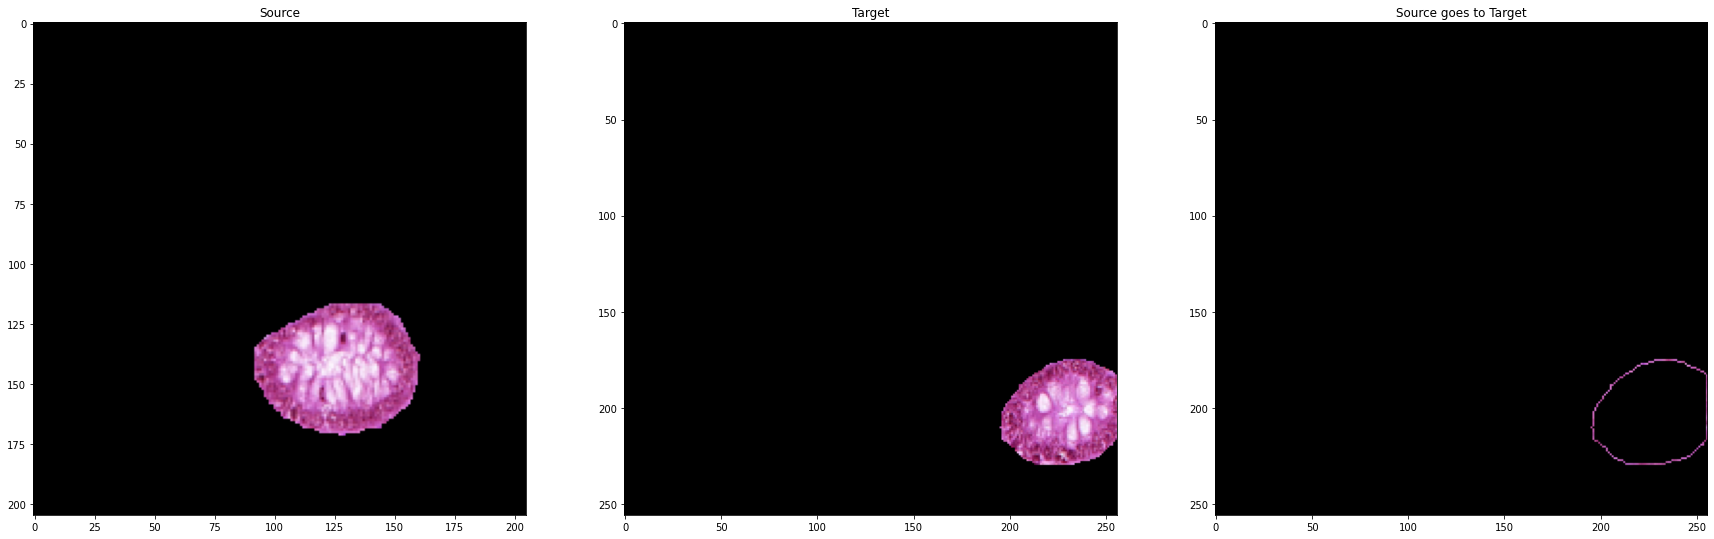

{'229,213': {'S_coor': [[118, 145], [119, 146]], 'S_represent': [[118, 145], [119, 146]]}, '228,212': {'S_coor': [[119, 146]], 'S_represent': [[119, 146]]}, '227,211': {'S_coor': [[119, 146], [119, 147], [120, 148]], 'S_represent': [[119, 146], [119, 147], [120, 148]]}, '227,210': {'S_coor': [[120, 148], [121, 149]], 'S_represent': [[120, 148], [121, 149]]}, '227,209': {'S_coor': [[121, 149], [122, 150]], 'S_represent': [[121, 149], [122, 150]]}, '226,208': {'S_coor': [[122, 150], [122, 151]], 'S_represent': [[122, 150], [122, 151]]}, '226,207': {'S_coor': [[122, 151], [123, 152]], 'S_represent': [[122, 151], [123, 152]]}, '225,206': {'S_coor': [[123, 152], [124, 152]], 'S_represent': [[123, 152], [124, 152]]}, '224,205': {'S_coor': [[124, 152], [125, 153]], 'S_represent': [[124, 152], [125, 153]]}, '223,204': {'S_coor': [[125, 153], [126, 153]], 'S_represent': [[125, 153], [126, 153]]}, '222,203': {'S_coor': [[126, 153]], 'S_represent': [[126, 153]]}, '221,203': {'S_coor': [[126, 153]

In [205]:
new = np.zeros_like(image_target) #image_target * (1-selected_target)[...,None]

for key in T_1.keys():
    length = len(T_1[key]['S_coor'])
    x_target, y_target = map(int, key.split(','))
    if length > 1:
        rgb = np.array([[[0,0,0]]])
        for pixels in T_1[key]['S_coor']:
            rgb += image_source_resized[pixels[0], pixels[1]]
        rgb = rgb.astype(np.float64)
        rgb /= length
        new[x_target, y_target, 0:] = rgb
    else:
        x_source, y_source = T_1[key]['S_represent'][0]
        # x_source, y_source = T_1[key]['S_represent']
        new[x_target, y_target, 0:] = image_source_resized[x_source, y_source, 0:]

new = new.astype(np.uint8)

plt.figure(figsize=(30,30))
plt.subplot(1,3,1)
plt.imshow(image_source_resized*selected_source_resized[...,None].astype(np.uint8))
plt.title('Source')

plt.subplot(1,3,2)
plt.imshow(image_target*selected_target[...,None].astype(np.uint8))
plt.title('Target')

plt.subplot(1,3,3)
plt.imshow(new)
plt.title('Source goes to Target')

plt.show()

print(T_1)

# 둘째 껍질부터

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


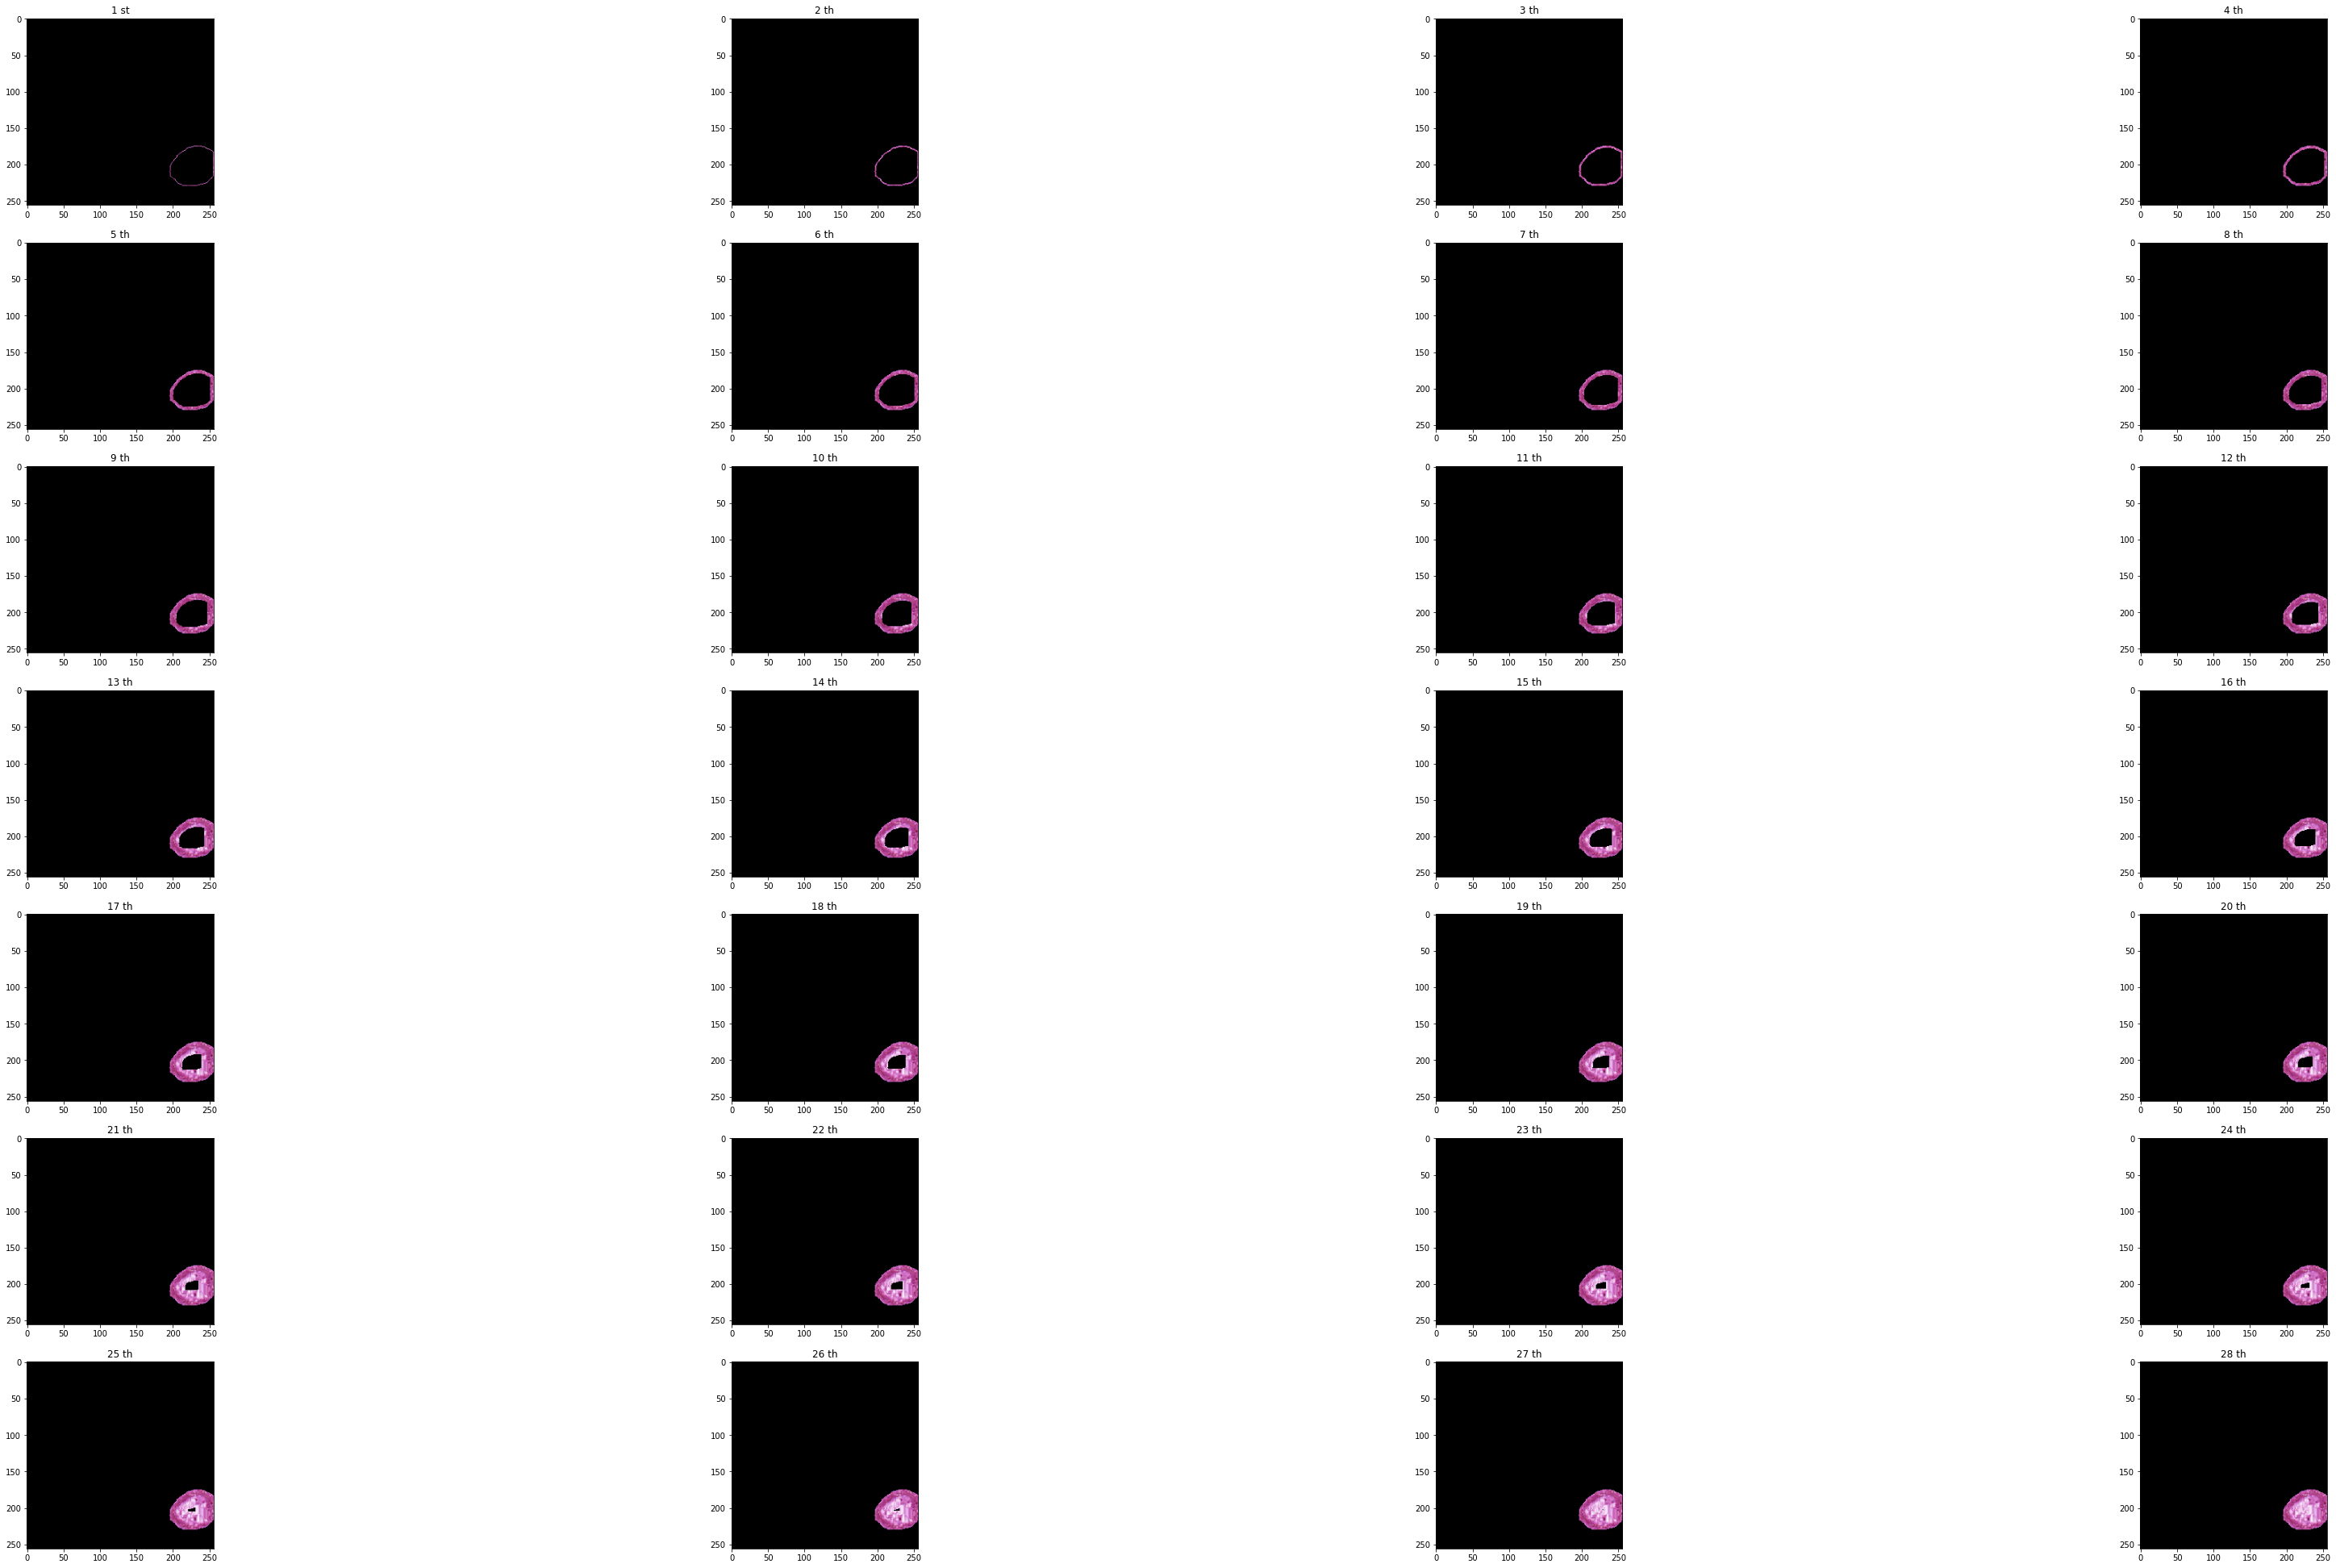

In [206]:
from collections import Counter
from tqdm import tqdm
from PIL import Image

plt.figure(figsize=(60,40))
plt.subplot(len(edges_source_resized)//4+1, 4, 1)
plt.imshow(new)
plt.title('1 st')

T_i_minus_1 = copy.deepcopy(T_1)
edge_source_i_minus_1 = edges_source_resized[0]
edge_target_i_minus_1 = edges_target[0]
edge_idx_i_minus_1_source = np.stack(np.where(edges_source_resized[0]==1),-1) # (length, 2)
edge_idx_i_minus_1_target = np.stack(np.where(edges_target[0]==1),-1)

h_max_t, w_max_t = imsize, imsize
h_max_s, w_max_s = imsize_source, imsize_source

for edge_idx in tqdm(range(1,len(edges_source_resized))):
    edge_source = edges_source_resized[edge_idx]
    edge_target = edges_target[edge_idx]

    edge_idx_source_h, edge_idx_source_w = np.where(edge_source==1)
    edge_idx_target_h, edge_idx_target_w = np.where(edge_target==1)

    T_i = {}
    for idx in range(len(edge_idx_target_h)):
        T_i[f'{edge_idx_target_h[idx]},{edge_idx_target_w[idx]}'] = {'S_coor':[], 'S_represent':[]}
    
    no_represent_key_list = []
    for idx, key in enumerate(T_i.keys()):
        h_target, w_target = map(int, key.split(','))
        mask_target = np.zeros_like(edge_target)
        mask_target[max(0,h_target-1):min(h_target+1+1, h_max_t),
                    max(0,w_target-1):min(w_target+1+1, w_max_t)] = 1
        neighbor_t_i = edge_target_i_minus_1 * mask_target
        neighbor_t_i_idx = np.stack(np.where(neighbor_t_i==1),-1) # T_i 상의 어떤 점 t_j에 대해 T_i-1에 있었던 이웃의 좌표 # T_{i-1}로 올라가고
        
        s_i_minus_1_represents = []
        for h_t, w_t in neighbor_t_i_idx: # T_i-1에 있던 좌표에 대해 # S_{i-1}에 대해
            for represent in T_i_minus_1[f'{h_t},{w_t}']['S_represent']: # S_i로 내려온다
                s_i_minus_1_represents.append(represent)
                h_source, w_source = represent
                mask_source = np.zeros_like(edge_source)
                mask_source[max(0,h_source-1):min(h_source+1+1, h_max_s),
                            max(0,w_source-1):min(w_source+1+1, w_max_s)] = 1
                neighbor_s_i = edge_source * mask_source
                neighbor_s_i_idx = np.stack(np.where(neighbor_s_i==1),-1) # S_i 상의 이웃하는 coordinates # (length, 2)
                T_i[key]['S_coor'] += neighbor_s_i_idx.tolist()

        # 실제 픽셀 값 주기
        if len(T_i[key]['S_coor']) != 0:
            counter = Counter(map(tuple, T_i[key]['S_coor']))
            count_elements = counter.most_common() # [((51, 147), 5), ((52, 147), 5), ... ]
            biggest_num = count_elements[0][1]
            T_i[key]['S_represent'] = [list(item[0]) for item in count_elements if item[1]==biggest_num]
            new[h_target, w_target] = np.sum(np.stack([image_source_resized[item[0], item[1]] for item in T_i[key]['S_represent']], axis=-1), axis=-1)/len(T_i[key]['S_represent'])
        else: # 아래껍질에 짝꿍없는애들
            s_i_minus_1_negihbors = []
            no_represent_key_list.append([h_target, w_target])
            for represent in s_i_minus_1_represents:
                h_source, w_source = represent
                mask_source = np.zeros_like(edge_source)
                mask_source[max(0,h_source-1):min(h_source+1+1, h_max_s),
                            max(0,w_source-1):min(w_source+1+1, w_max_s)] = 1
                neighbor_s_i_minus_1 = edge_source_i_minus_1 * mask_source
                neighbor_s_i_minus_1_idx = np.stack(np.where(neighbor_s_i_minus_1==1),-1).tolist()
                s_i_minus_1_negihbors += neighbor_s_i_minus_1_idx
                new[h_target, w_target] = np.sum(np.stack([image_source_resized[item[0], item[1]] for item in s_i_minus_1_negihbors], axis=-1), axis=-1)/len(s_i_minus_1_negihbors)
    
    # S_represent없는 key 들에게 할당해주기
    while len(no_represent_key_list) != 0:
        if edge_idx+1 == len(edges_source_resized):
            break
        for item in no_represent_key_list:
            h_target, w_target = item
            key = f'{h_target},{w_target}'
            s_represent = []
            negihbors = [f'{int(h_target-1)},{int(w_target-1)}',
                         f'{int(h_target-1)},{int(w_target)}',
                         f'{int(h_target-1)},{int(w_target+1)}',
                         f'{int(h_target)},{int(w_target+1)}',
                         f'{int(h_target)},{int(w_target-1)}',
                         f'{int(h_target+1)},{int(w_target-1)}',
                         f'{int(h_target+1)},{int(w_target)}',
                         f'{int(h_target+1)},{int(w_target+1)}',]
            for neigbor in negihbors:
                try:
                    s_represent += T_i[neigbor]['S_represent']
                except:
                    pass

            if len(s_represent) >= 1:
                T_i[key]['S_represent'] = s_represent
                no_represent_key_list.remove(item)

    # variables for next step
    T_i_minus_1 = T_i
    edge_source_i_minus_1 = edges_source_resized[edge_idx]
    edge_target_i_minus_1 = edges_target[edge_idx]
    edge_idx_i_minus_1_source = np.stack(np.where(edges_source_resized[edge_idx]==1),-1)
    edge_idx_i_minus_1_target = np.stack(np.where(edges_target[edge_idx]==1),-1)

    # plot       
    plt.subplot(len(edges_source_resized)//4+1, 4, edge_idx+1)
    plt.imshow(new)
    plt.title(f'{edge_idx+1} th')

    # save
    save_image = Image.fromarray(new.astype(np.uint8))
    save_image.save(f'./cp_rebirth/{edge_idx}.png')

plt.show()

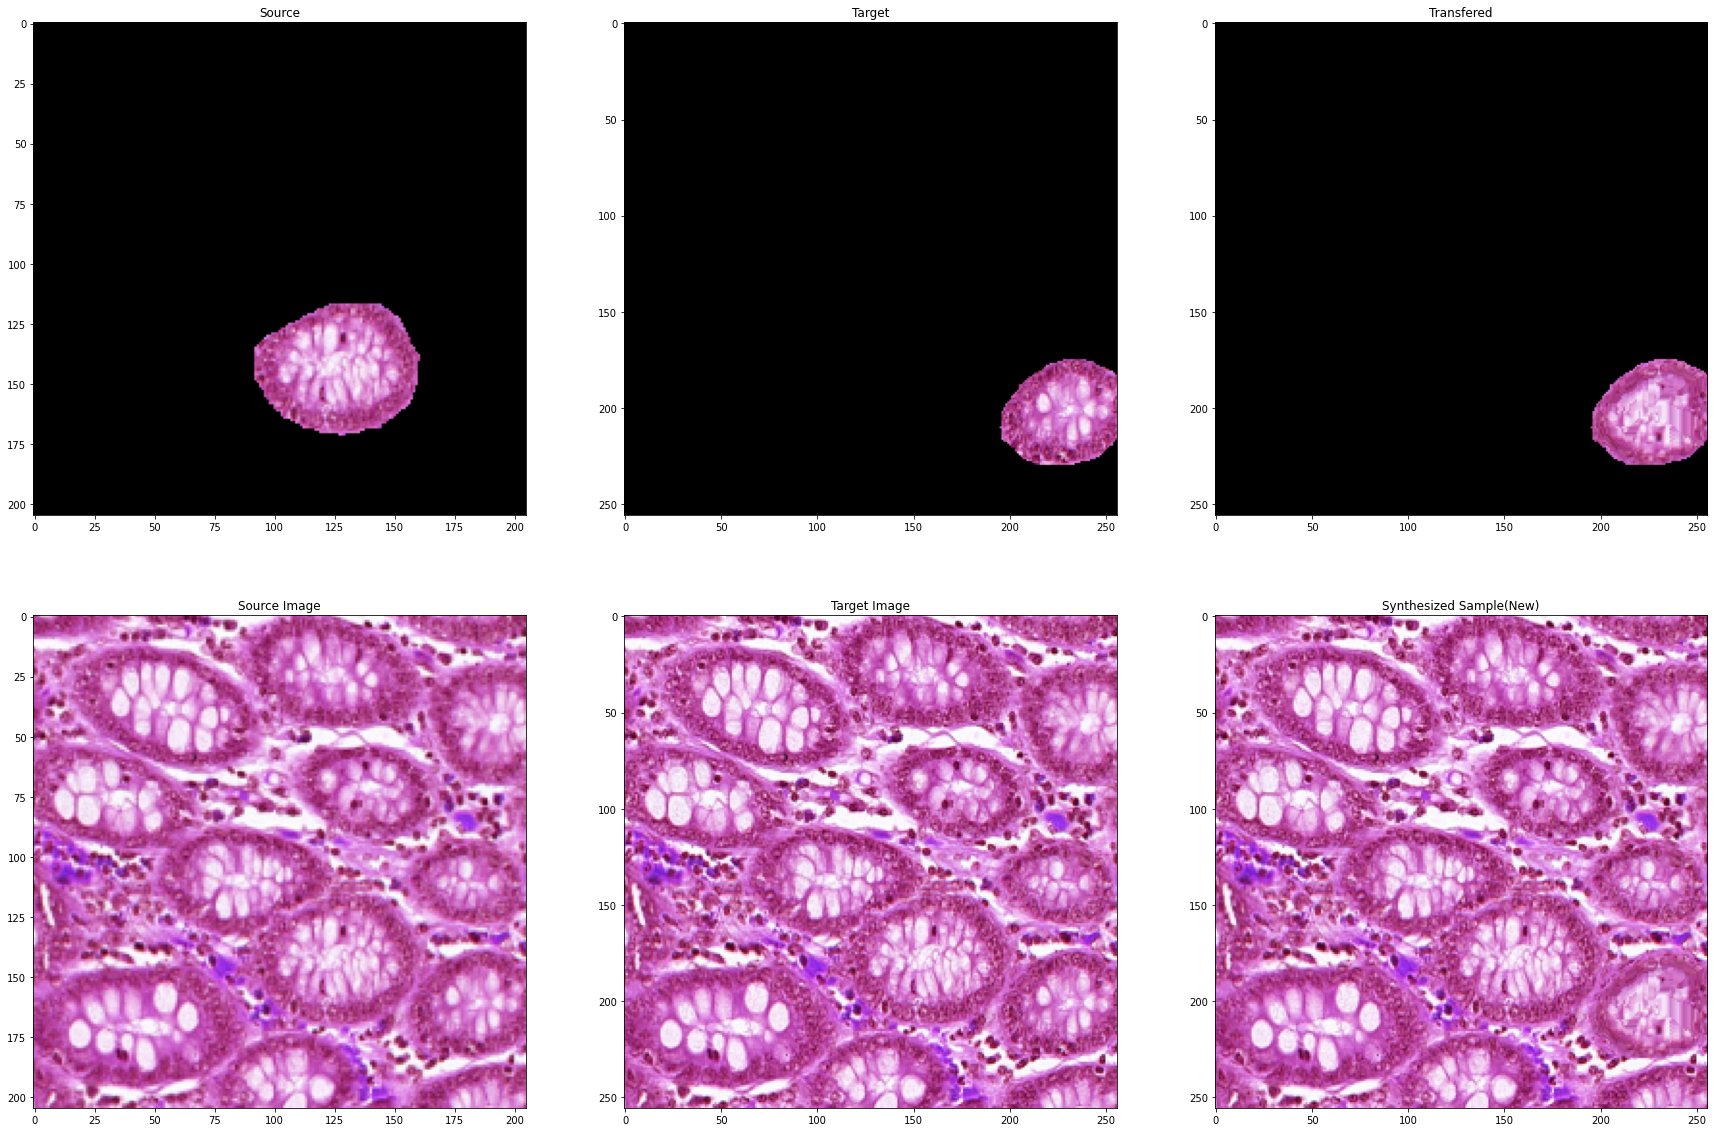

In [207]:
plt.figure(figsize=(30,20))

plt.subplot(2,3,1)
plt.imshow((image_source_resized * selected_source_resized[...,None]).astype(np.uint8))
plt.title('Source')

plt.subplot(2,3,2)
plt.imshow((image_target * selected_target[...,None]).astype(np.uint8))
plt.title('Target')

plt.subplot(2,3,3)
# plt.imshow(cv2.GaussianBlur(new, (0,0), 0.6))
plt.imshow(new)
plt.title('Transfered')

plt.subplot(2,3,4)
plt.imshow(image_source_resized)
plt.title("Source Image")

plt.subplot(2,3,5)
plt.imshow(image_target)
plt.title("Target Image")

plt.subplot(2,3,6)
plt.imshow((image_target*(1-selected_target)[...,None] + new).astype(np.uint8))
plt.title("Synthesized Sample(New)")

plt.show()

# Nuclei 해보기
## 1. 데이터 불러오기

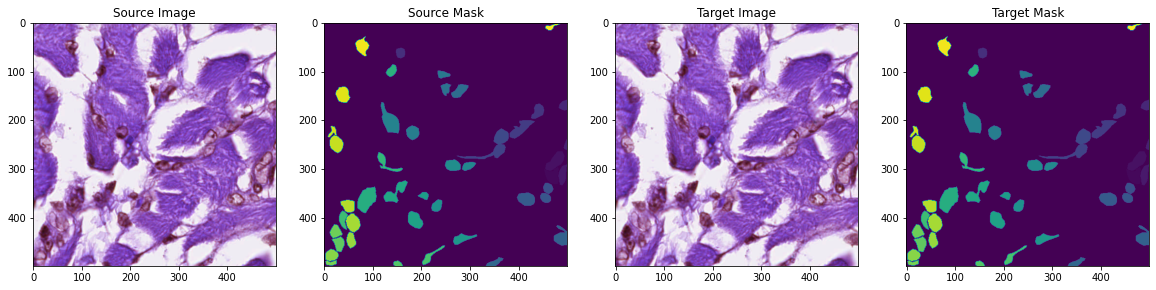

In [433]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import io


imsize = 256
source = '08'
target = '08'

image_source = cv2.imread(f'E:/cpm17/train/Images/image_{source}.png', cv2.IMREAD_COLOR)
mask_source = io.loadmat(f'E:/cpm17/train/Labels/image_{source}.mat')['inst_map']

image_target = cv2.imread(f'E:/cpm17/train/Images/image_{target}.png', cv2.IMREAD_COLOR)
mask_target= io.loadmat(f'E:/cpm17/train/Labels/image_{target}.mat')['inst_map']

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(image_source)
plt.title('Source Image')

plt.subplot(1,4,2)
plt.imshow(mask_source)
plt.title('Source Mask')

plt.subplot(1,4,3)
plt.imshow(image_target)
plt.title('Target Image')

plt.subplot(1,4,4)
plt.imshow(mask_target)
plt.title('Target Mask')

plt.show()

In [2]:
import tifffile

# TIFF 이미지 열기
image = tifffile.imread('E:/kumar/train/Images/TCGA-18-5592-01Z-00-DX1.tif')

# 이미지 정보 출력
print('Image shape:', image.shape)  # 이미지 크기 출력
print('Data type:', type(image))     # 데이터 타입 출력
print('Image data:', image)          # 이미지 데이터 출력


Image shape: (1000, 1000, 3)
Data type: <class 'numpy.ndarray'>
Image data: [[[181  88 132]
  [180  87 131]
  [179  86 130]
  ...
  [155  74 114]
  [155  74 114]
  [157  75 123]]

 [[185  90 132]
  [185  90 132]
  [185  90 132]
  ...
  [157  78 118]
  [157  78 118]
  [158  78 123]]

 [[187  92 132]
  [187  92 132]
  [188  93 133]
  ...
  [155  83 123]
  [156  84 124]
  [160  80 123]]

 ...

 [[186  97 135]
  [185  96 134]
  [188  99 137]
  ...
  [144  68 115]
  [143  67 114]
  [138  72 120]]

 [[179  93 132]
  [177  91 130]
  [184  98 137]
  ...
  [146  68 116]
  [147  69 117]
  [143  72 122]]

 [[181  96 137]
  [181  95 134]
  [180  94 133]
  ...
  [143  67 114]
  [144  68 115]
  [142  71 121]]]


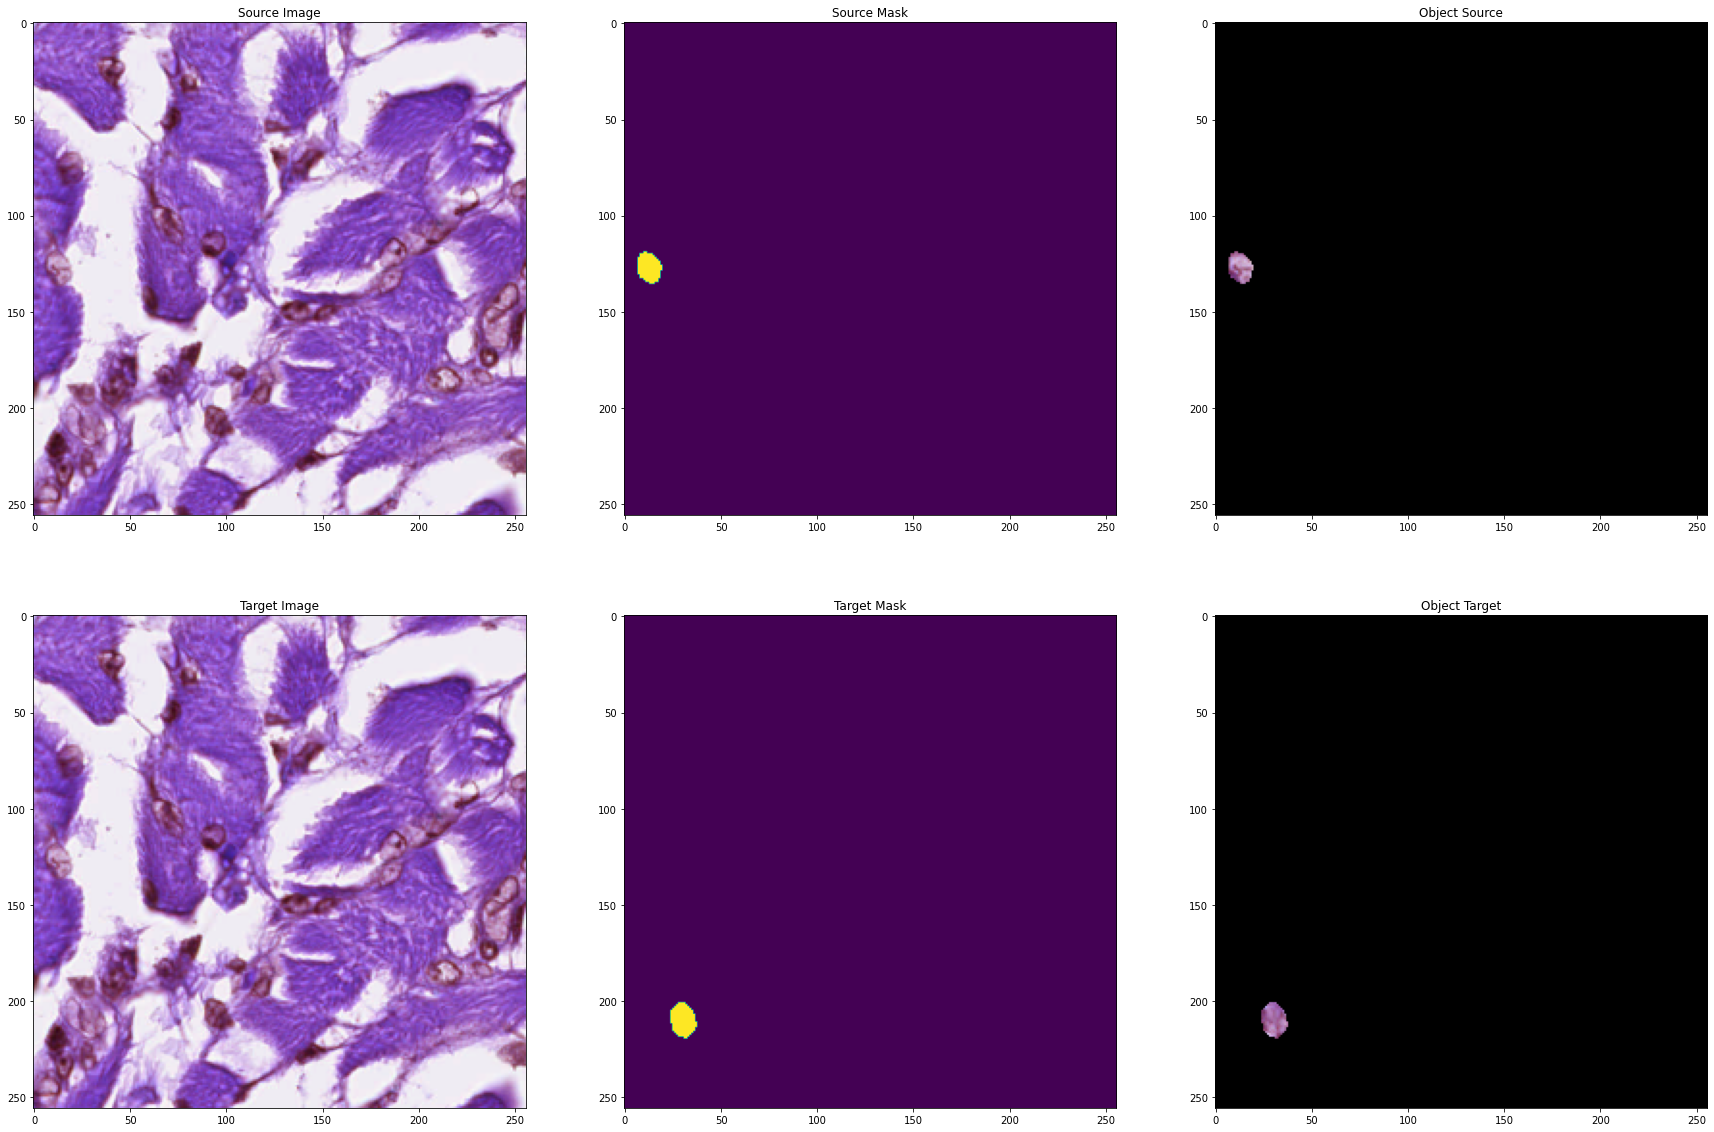

In [434]:
object_source_idx = random.choice(np.unique(mask_source)[1:]) # 0번은 배경을 선택해버린다
object_target_idx = random.choice(np.unique(mask_target)[1:]) # 0번은 배경을 선택해버린다

selected_source = np.where((mask_source==object_source_idx)==1.0,1.0,0)
selected_source = cv2.resize(selected_source.astype(np.float32), (imsize,imsize))
selected_source = np.where(selected_source>0.0, 1.0, 0.0)

selected_target = np.where((mask_target==object_target_idx)==1.0,1.0,0)
selected_target = cv2.resize(selected_target.astype(np.float32), (imsize,imsize))
selected_target = np.where(selected_target>0.0, 1.0, 0.0)

image_source = cv2.resize(image_source, (imsize,imsize))
mask_source = cv2.resize(mask_source.astype(np.float32), (imsize,imsize))

image_target = cv2.resize(image_target, (imsize,imsize))
mask_target = cv2.resize(mask_target.astype(np.float32), (imsize,imsize))

_, onions = onion_peeling(selected_source, prune_all=False)
selected_source = onions[1]

_, onions = onion_peeling(selected_target, prune_all=False)
selected_target = onions[1]

plt.figure(figsize=(30,20))
plt.subplot(2,3,1)
plt.imshow(image_source)
plt.title('Source Image')

plt.subplot(2,3,2)
plt.imshow(selected_source)
plt.title('Source Mask')

plt.subplot(2,3,3)
plt.imshow((image_source * selected_source[...,None]).astype(np.uint8))
plt.title('Object Source')

plt.subplot(2,3,4)
plt.imshow(image_target)
plt.title('Target Image')

plt.subplot(2,3,5)
plt.imshow(selected_target)
plt.title('Target Mask')

plt.subplot(2,3,6)
plt.imshow((image_target * selected_target[...,None]).astype(np.uint8))
plt.title('Object Target')

plt.show()

## 2. 라플라시안 필터

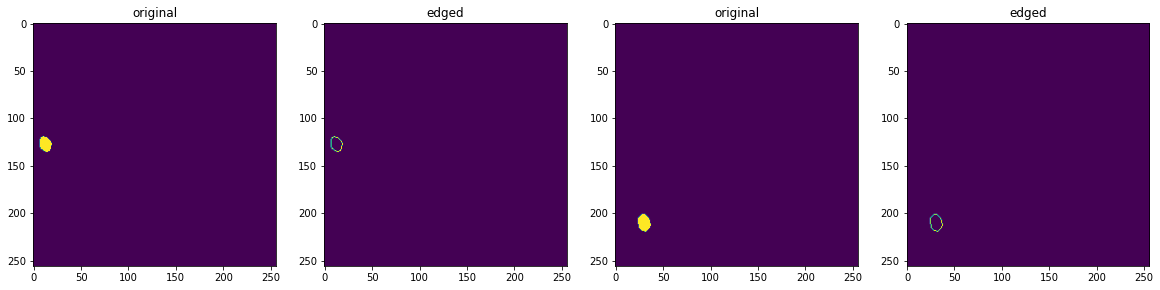

In [435]:
selected_source_boundary = np.zeros((imsize,imsize))
selected_source_boundary[0,0:] = selected_source[0,0:]
selected_source_boundary[-1,0:] = selected_source[-1,0:]
selected_source_boundary[0:,0] = selected_source[0:,0]
selected_source_boundary[0:,-1] = selected_source[0:,-1]

selected_target_boundary = np.zeros((imsize,imsize))
selected_target_boundary[0,0:] = selected_target[0,0:]
selected_target_boundary[-1,0:] = selected_target[-1,0:]
selected_target_boundary[0:,0] = selected_target[0:,0]
selected_target_boundary[0:,-1] = selected_target[0:,-1]


pad_size = 1
laplacianFilter = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
selected_source_edge = np.where(cv2.filter2D(np.pad(selected_source,(pad_size,pad_size),mode='constant'),-1,laplacianFilter)[pad_size:-pad_size,pad_size:-pad_size]>0,1.0,0)
selected_target_edge = np.where(cv2.filter2D(np.pad(selected_target,(pad_size,pad_size),mode='constant'),-1,laplacianFilter)[pad_size:-pad_size,pad_size:-pad_size]>0,1.0,0)

plt.figure(figsize=(20,40))
plt.subplot(1,4,1)
plt.imshow(selected_source)
plt.title('original')

plt.subplot(1,4,2)
plt.imshow(selected_source_edge)
plt.title('edged')

plt.subplot(1,4,3)
plt.imshow(selected_target)
plt.title('original')

plt.subplot(1,4,4)
plt.imshow(selected_target_edge)
plt.title('edged')
plt.show()

## 3. edge pruning

source edge : 41.0 -> 41.0
target edge : 42.0 -> 42.0


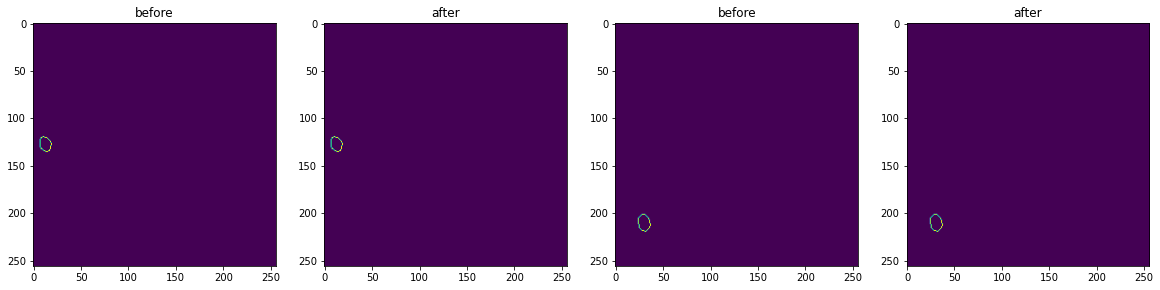

In [436]:
pruned_source_edge = prune_edge(selected_source_edge)
pruned_target_edge = prune_edge(selected_target_edge)

print(f'source edge : {np.sum(selected_source_edge)} -> {np.sum(pruned_source_edge)}')
print(f'target edge : {np.sum(selected_target_edge)} -> {np.sum(pruned_target_edge)}')


plt.figure(figsize=(20,40))
plt.subplot(1,4,1)
plt.imshow(selected_source_edge)
plt.title('before')

plt.subplot(1,4,2)
plt.imshow(pruned_source_edge)
plt.title('after')

plt.subplot(1,4,3)
plt.imshow(selected_target_edge)
plt.title('before')

plt.subplot(1,4,4)
plt.imshow(pruned_target_edge)
plt.title('after')
plt.show()

## 4. 무어 알고리즘

127 12
209 30


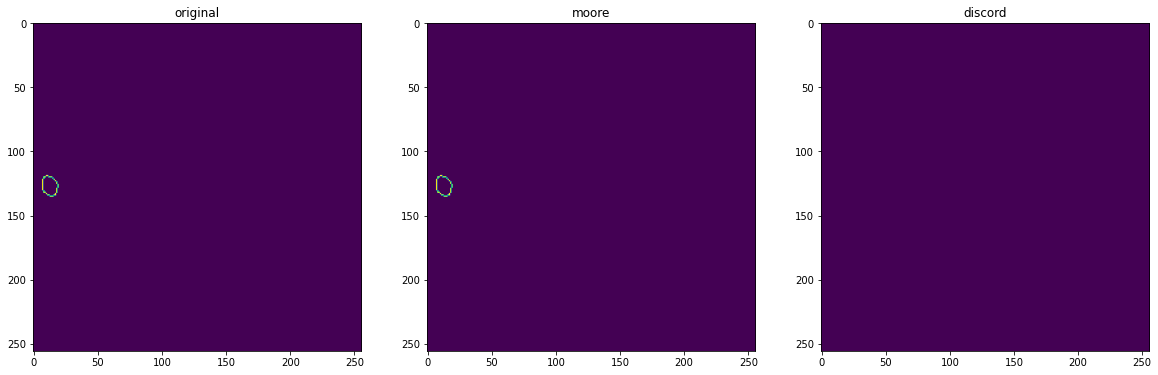

moore algorithm이 성공적으로 edge를 flatten하였습니다.


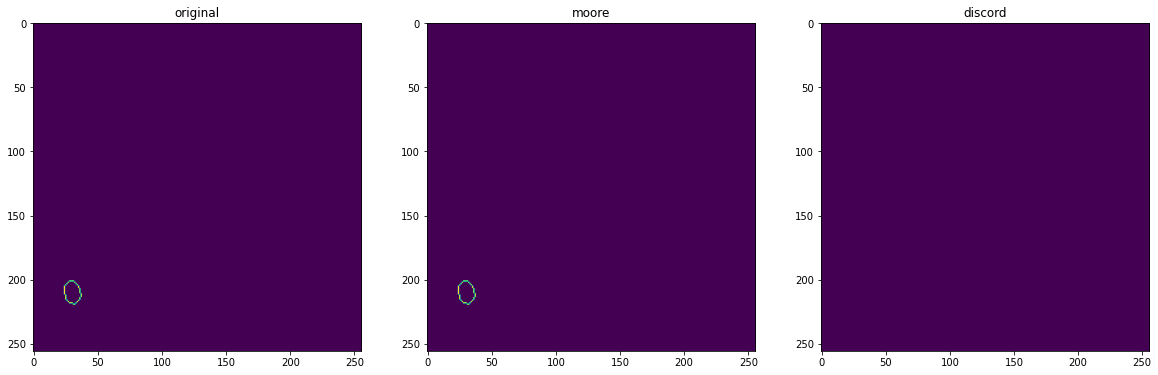

moore algorithm이 성공적으로 edge를 flatten하였습니다.


In [437]:
if __name__ == '__main__':
    coordinate = get_coordinate(imsize,imsize)
    coordinate_source = coordinate * selected_source[...,None] # (imsize,imsize,2)
    coordinate_target = coordinate * selected_target[...,None] # (imsize,imsize,2)
    coordinate_source_edge = coordinate * selected_source_edge[...,None] # (imsize,imsize,2)
    coordinate_target_edge = coordinate * selected_target_edge[...,None] # (imsize,imsize,2)

    centroid_source = np.sum(np.sum(coordinate_source, 0),0) / np.sum(selected_source)
    centroid_target = np.sum(np.sum(coordinate_target, 0),0) / np.sum (selected_target)
    centroid_x_source, centroid_y_source = int(centroid_source[0]), int(centroid_source[1])
    centroid_x_target, centroid_y_target = int(centroid_target[0]), int(centroid_target[1])

    flatten_source = moore_algorithm(pruned_source_edge)
    flatten_target = moore_algorithm(pruned_target_edge)

    print(centroid_x_source, centroid_y_source)
    print(centroid_x_target, centroid_y_target)


    moore_mask = np.zeros_like(pruned_source_edge)
    for x,y in flatten_source:
        moore_mask[x,y] = 1

    discord = 1 - (moore_mask == pruned_source_edge)

    plt.figure(figsize=(20,10))

    plt.subplot(1,3,1)
    plt.imshow(pruned_source_edge)
    plt.title('original')

    plt.subplot(1,3,2)
    plt.imshow(moore_mask)
    plt.title('moore')

    plt.subplot(1,3,3)
    plt.imshow(discord)
    plt.title('discord')

    plt.show()

    if np.sum(discord) == 0:
        print('moore algorithm이 성공적으로 edge를 flatten하였습니다.')
    else:
        print('moore algorithm이 edge를 flatten하지 못했습니다.')


    moore_mask = np.zeros_like(pruned_target_edge)
    for x,y in flatten_target:
        moore_mask[x,y] = 1

    discord = 1 - (moore_mask == pruned_target_edge)

    plt.figure(figsize=(20,10))

    plt.subplot(1,3,1)
    plt.imshow(pruned_target_edge)
    plt.title('original')

    plt.subplot(1,3,2)
    plt.imshow(moore_mask)
    plt.title('moore')

    plt.subplot(1,3,3)
    plt.imshow(discord)
    plt.title('discord')

    plt.show()

    if np.sum(discord) == 0:
        print('moore algorithm이 성공적으로 edge를 flatten하였습니다.')
    else:
        print('moore algorithm이 edge를 flatten하지 못했습니다.')

## 5. 양파까기

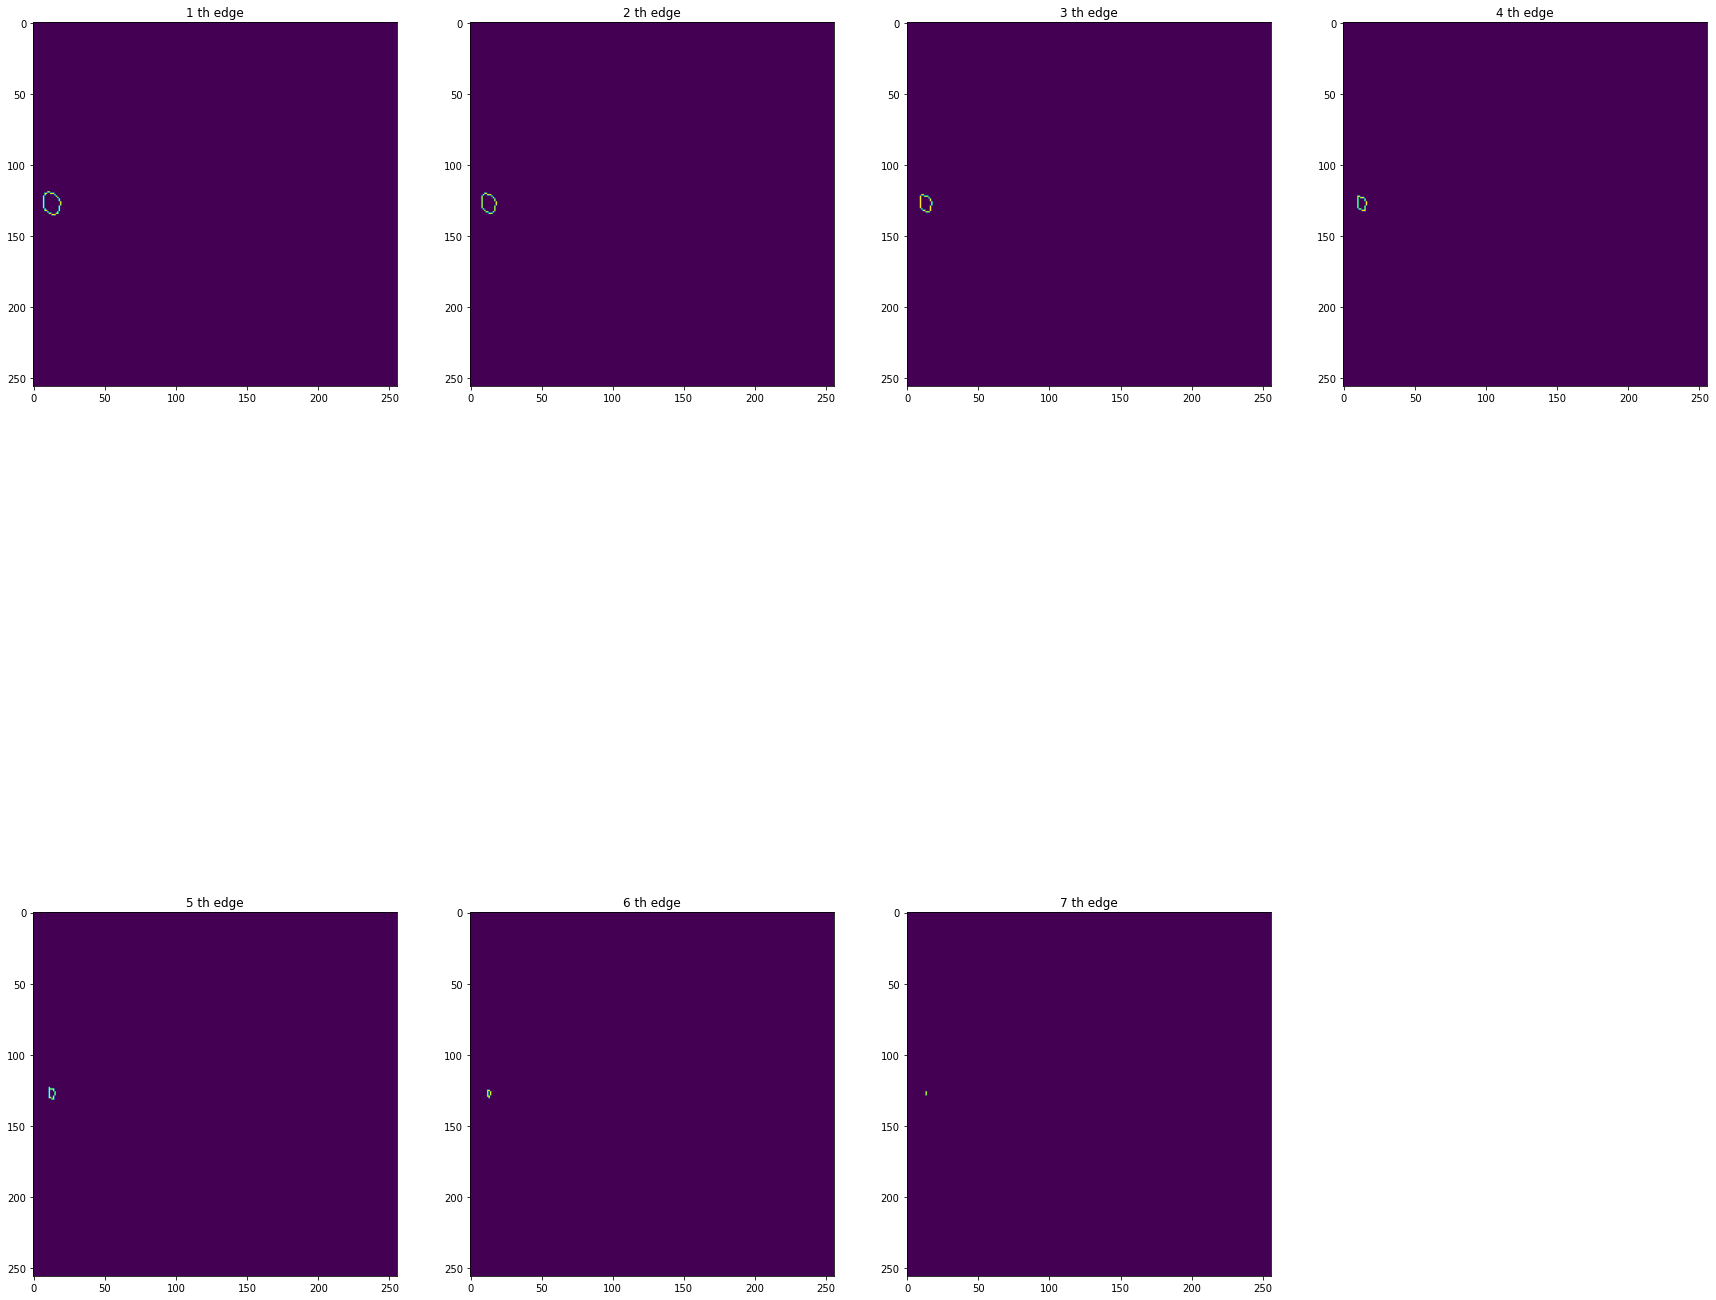

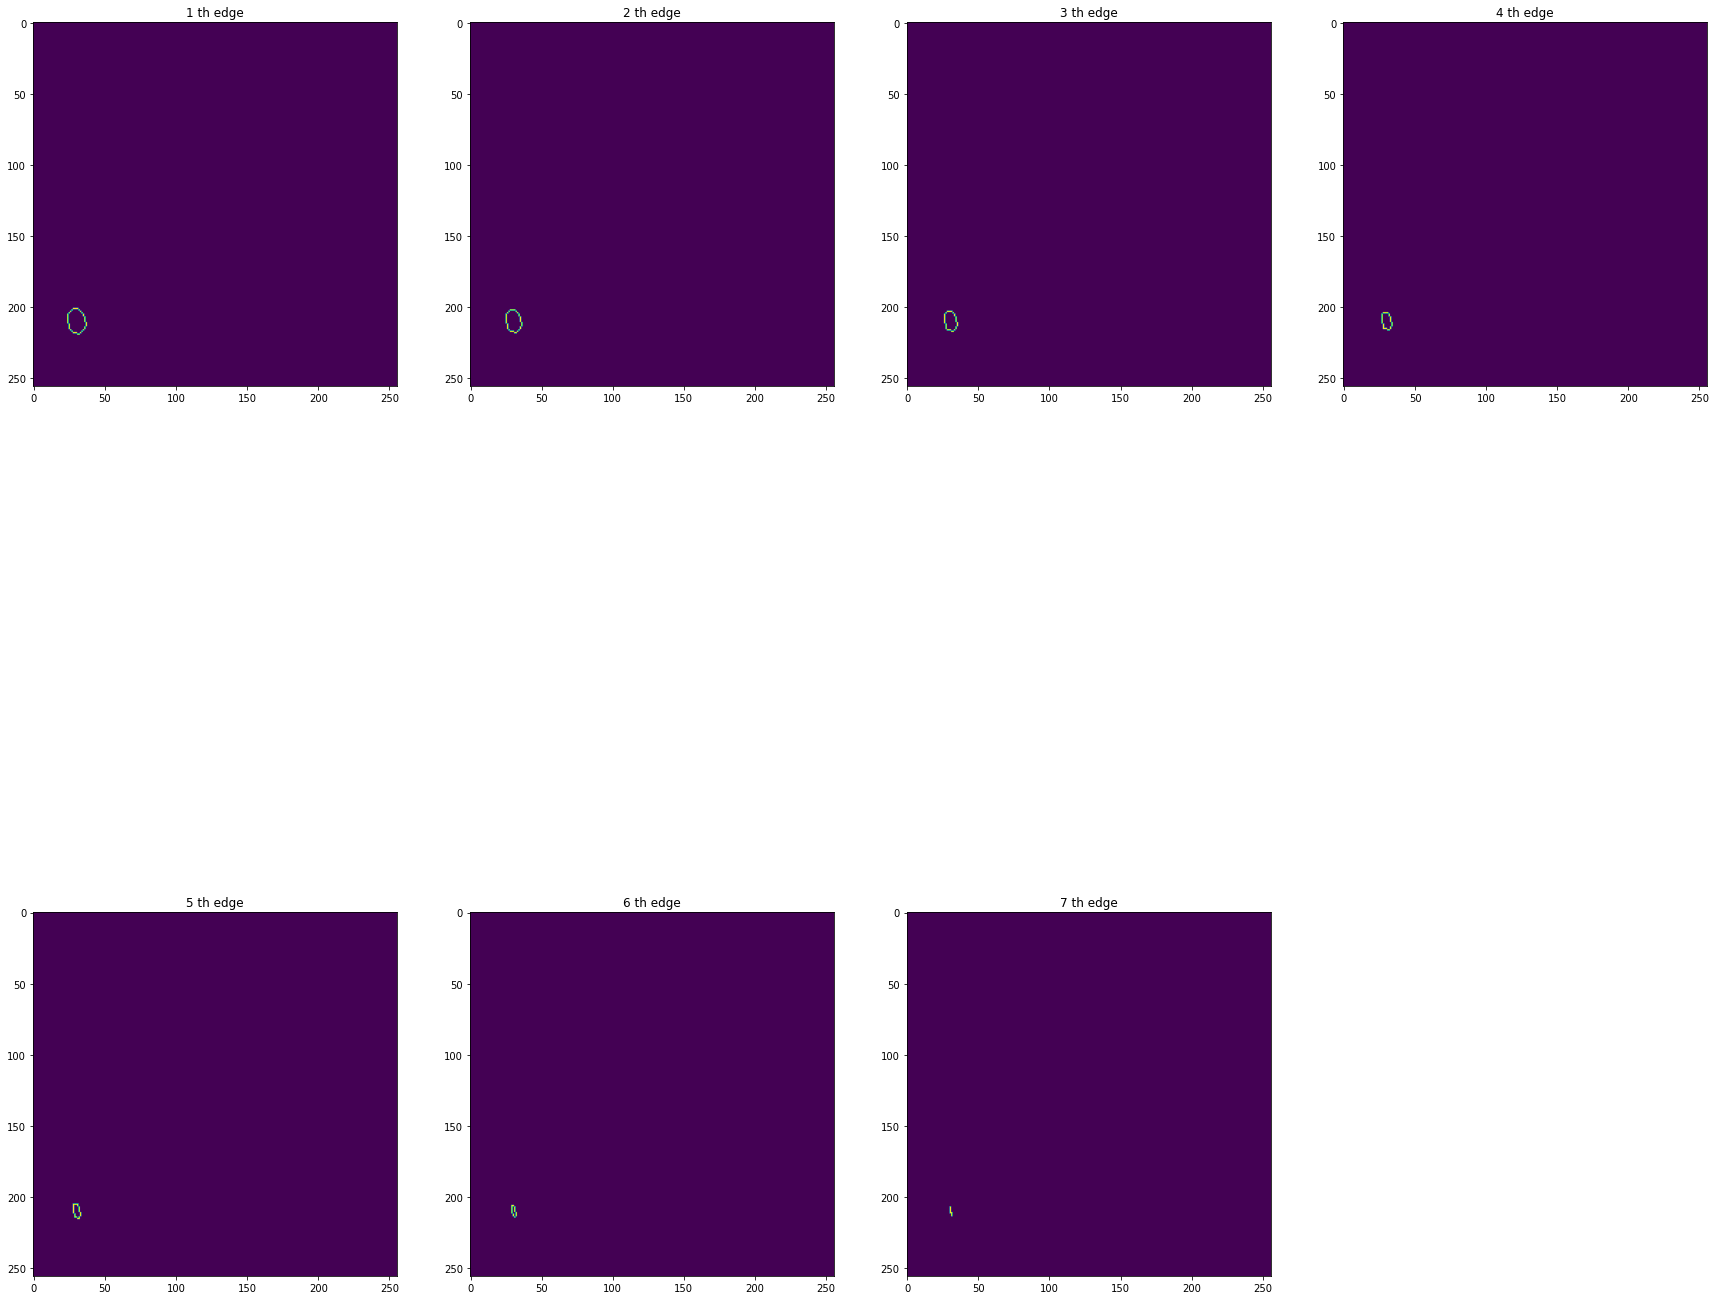

In [438]:
edges_source, _ = onion_peeling(selected_source)
    
i = len(edges_source)
plt.figure(figsize=(30,30))
for idx in range(1,i+1):
    plt.subplot(i//4+1,4,idx)
    plt.imshow(edges_source[idx-1])
    plt.title(f'{idx} th edge')

plt.show()


edges_target, _ = onion_peeling(selected_target)

i = len(edges_target)
plt.figure(figsize=(30,30))
for idx in range(1,i+1):
    plt.subplot(i//4+1,4,idx)
    plt.imshow(edges_target[idx-1])
    plt.title(f'{idx} th edge')

plt.show()

## 6. 껍질 수 맞추기

In [439]:
if __name__ == '__main__':
    image_source_resized, selected_source_resized, edges_source_resized, onions_source_resized, imsize_source = resize_and_onion_peeling(edges_source, edges_target, selected_source)
    print(f'Target의 껍질 수 : {len(edges_target)}, Source의 껍질 수 : {len(edges_source_resized)}')

    coordinate = get_coordinate(imsize_source,imsize_source)
    coordinate_source_resized = coordinate * selected_source_resized[...,None] # (imsize_source,imsize_source,2)
    coordinate_source_edge_resized = coordinate * edges_source_resized[0][...,None] # (imsize,imsize,2)


    centroid_source_resized = np.sum(np.sum(coordinate_source_resized, 0),0) / np.sum(selected_source_resized)
    centroid_x_source_resized, centroid_y_source_resized = int(centroid_source_resized[0]), int(centroid_source_resized[1])

    flatten_source_resized = moore_algorithm(edges_source_resized[0])

    print(centroid_x_source_resized, centroid_y_source_resized)
    print(len(flatten_target), len(flatten_source_resized))

Target의 껍질 수 : 7, Source의 껍질 수 : 7
127 12
43 42


## 7. 첫 껍질 DTW

In [440]:
if __name__ == '__main__':
    centroid_moved_flatten_source = copy.deepcopy(flatten_source_resized)
    centroid_moved_flatten_source[...,0] -= centroid_x_source_resized
    centroid_moved_flatten_source[...,1] -= centroid_y_source_resized

    centroid_moved_flatten_target = copy.deepcopy(flatten_target)
    centroid_moved_flatten_target[...,0] -= centroid_x_target
    centroid_moved_flatten_target[...,1] -= centroid_y_target

    warping_idx, cost_matrix, self_cost_matrix = dtw(centroid_moved_flatten_source[0:-1], centroid_moved_flatten_target[0:-1], True)

    print(f'Source edge length : {len(flatten_source_resized)}, Target edge length : {len(flatten_target)}')

Source edge length : 42, Target edge length : 43


42 42.0


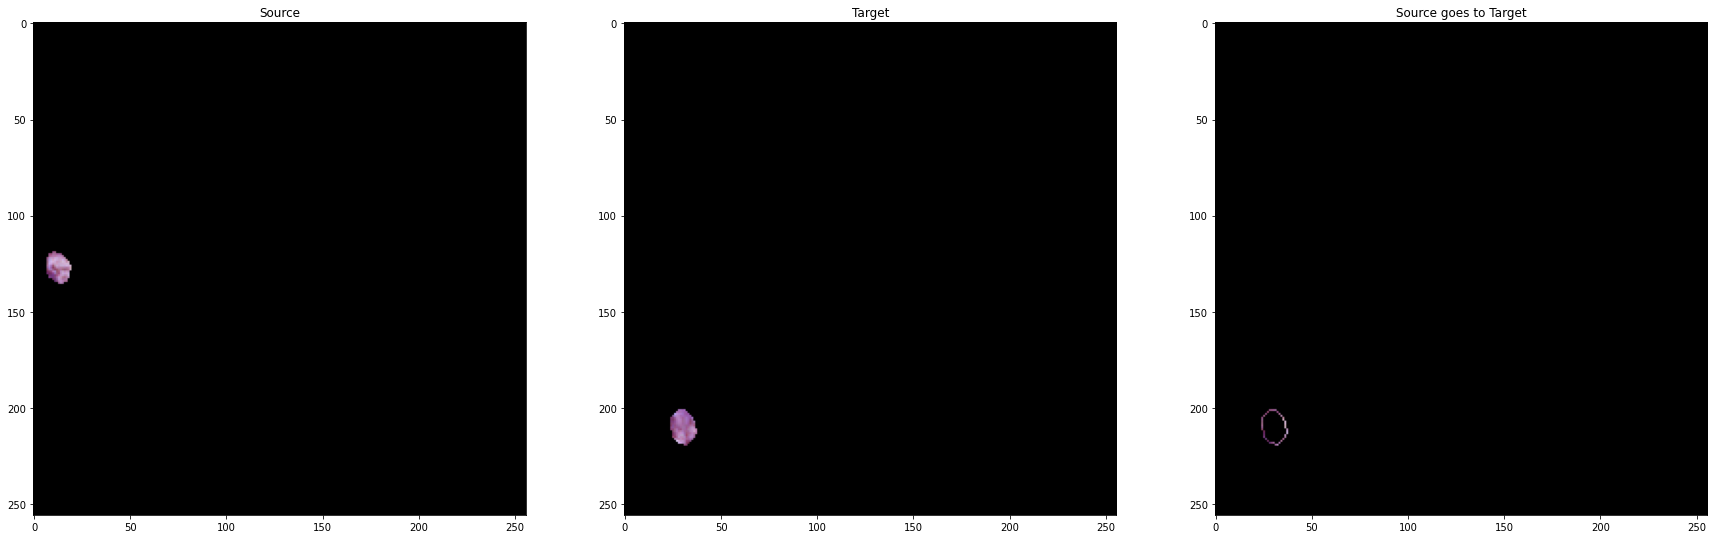

{'219,31': {'S_coor': [[135, 13]], 'S_represent': [[135, 13]]}, '218,30': {'S_coor': [[135, 13]], 'S_represent': [[135, 13]]}, '218,29': {'S_coor': [[134, 12]], 'S_represent': [[134, 12]]}, '218,28': {'S_coor': [[134, 11]], 'S_represent': [[134, 11]]}, '217,27': {'S_coor': [[133, 10]], 'S_represent': [[133, 10]]}, '216,26': {'S_coor': [[132, 9]], 'S_represent': [[132, 9]]}, '215,25': {'S_coor': [[132, 8]], 'S_represent': [[132, 8]]}, '214,25': {'S_coor': [[131, 8]], 'S_represent': [[131, 8]]}, '213,25': {'S_coor': [[130, 7]], 'S_represent': [[130, 7]]}, '212,25': {'S_coor': [[129, 7]], 'S_represent': [[129, 7]]}, '211,24': {'S_coor': [[128, 7]], 'S_represent': [[128, 7]]}, '210,24': {'S_coor': [[127, 7]], 'S_represent': [[127, 7]]}, '209,24': {'S_coor': [[126, 7]], 'S_represent': [[126, 7]]}, '208,24': {'S_coor': [[125, 7]], 'S_represent': [[125, 7]]}, '207,24': {'S_coor': [[124, 7]], 'S_represent': [[124, 7]]}, '206,24': {'S_coor': [[123, 7]], 'S_represent': [[123, 7]]}, '205,24': {'S

In [441]:
T_1 = {}

for x,y in flatten_target:
    T_1[f'{x},{y}'] = {'S_coor':[], 'S_represent':None}

for idx_source, idx_target in warping_idx:
    x_target, y_target = flatten_target[idx_target]
    x_source, y_source = flatten_source_resized[idx_source]
    T_1[f'{x_target},{y_target}']['S_coor'].append([x_source, y_source])

for key in T_1.keys():
    allocated_S_coors = len(T_1[key]['S_coor'])
    assert allocated_S_coors>=1
    T_1[key]['S_represent'] = T_1[key]['S_coor']

print(len(T_1), np.sum(edges_target[0]))


new = np.zeros_like(image_target) #image_target * (1-selected_target)[...,None]

for key in T_1.keys():
    length = len(T_1[key]['S_coor'])
    x_target, y_target = map(int, key.split(','))
    if length > 1:
        rgb = np.array([[[0,0,0]]])
        for pixels in T_1[key]['S_coor']:
            rgb += image_source_resized[pixels[0], pixels[1]]
        rgb = rgb.astype(np.float64)
        rgb /= length
        new[x_target, y_target, 0:] = rgb
    else:
        x_source, y_source = T_1[key]['S_represent'][0]
        # x_source, y_source = T_1[key]['S_represent']
        new[x_target, y_target, 0:] = image_source_resized[x_source, y_source, 0:]

new = new.astype(np.uint8)

plt.figure(figsize=(30,30))
plt.subplot(1,3,1)
plt.imshow(image_source_resized*selected_source_resized[...,None].astype(np.uint8))
plt.title('Source')

plt.subplot(1,3,2)
plt.imshow(image_target*selected_target[...,None].astype(np.uint8))
plt.title('Target')

plt.subplot(1,3,3)
plt.imshow(new)
plt.title('Source goes to Target')

plt.show()

print(T_1)

## 8. 둘째 껍질부터

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 19.02it/s]


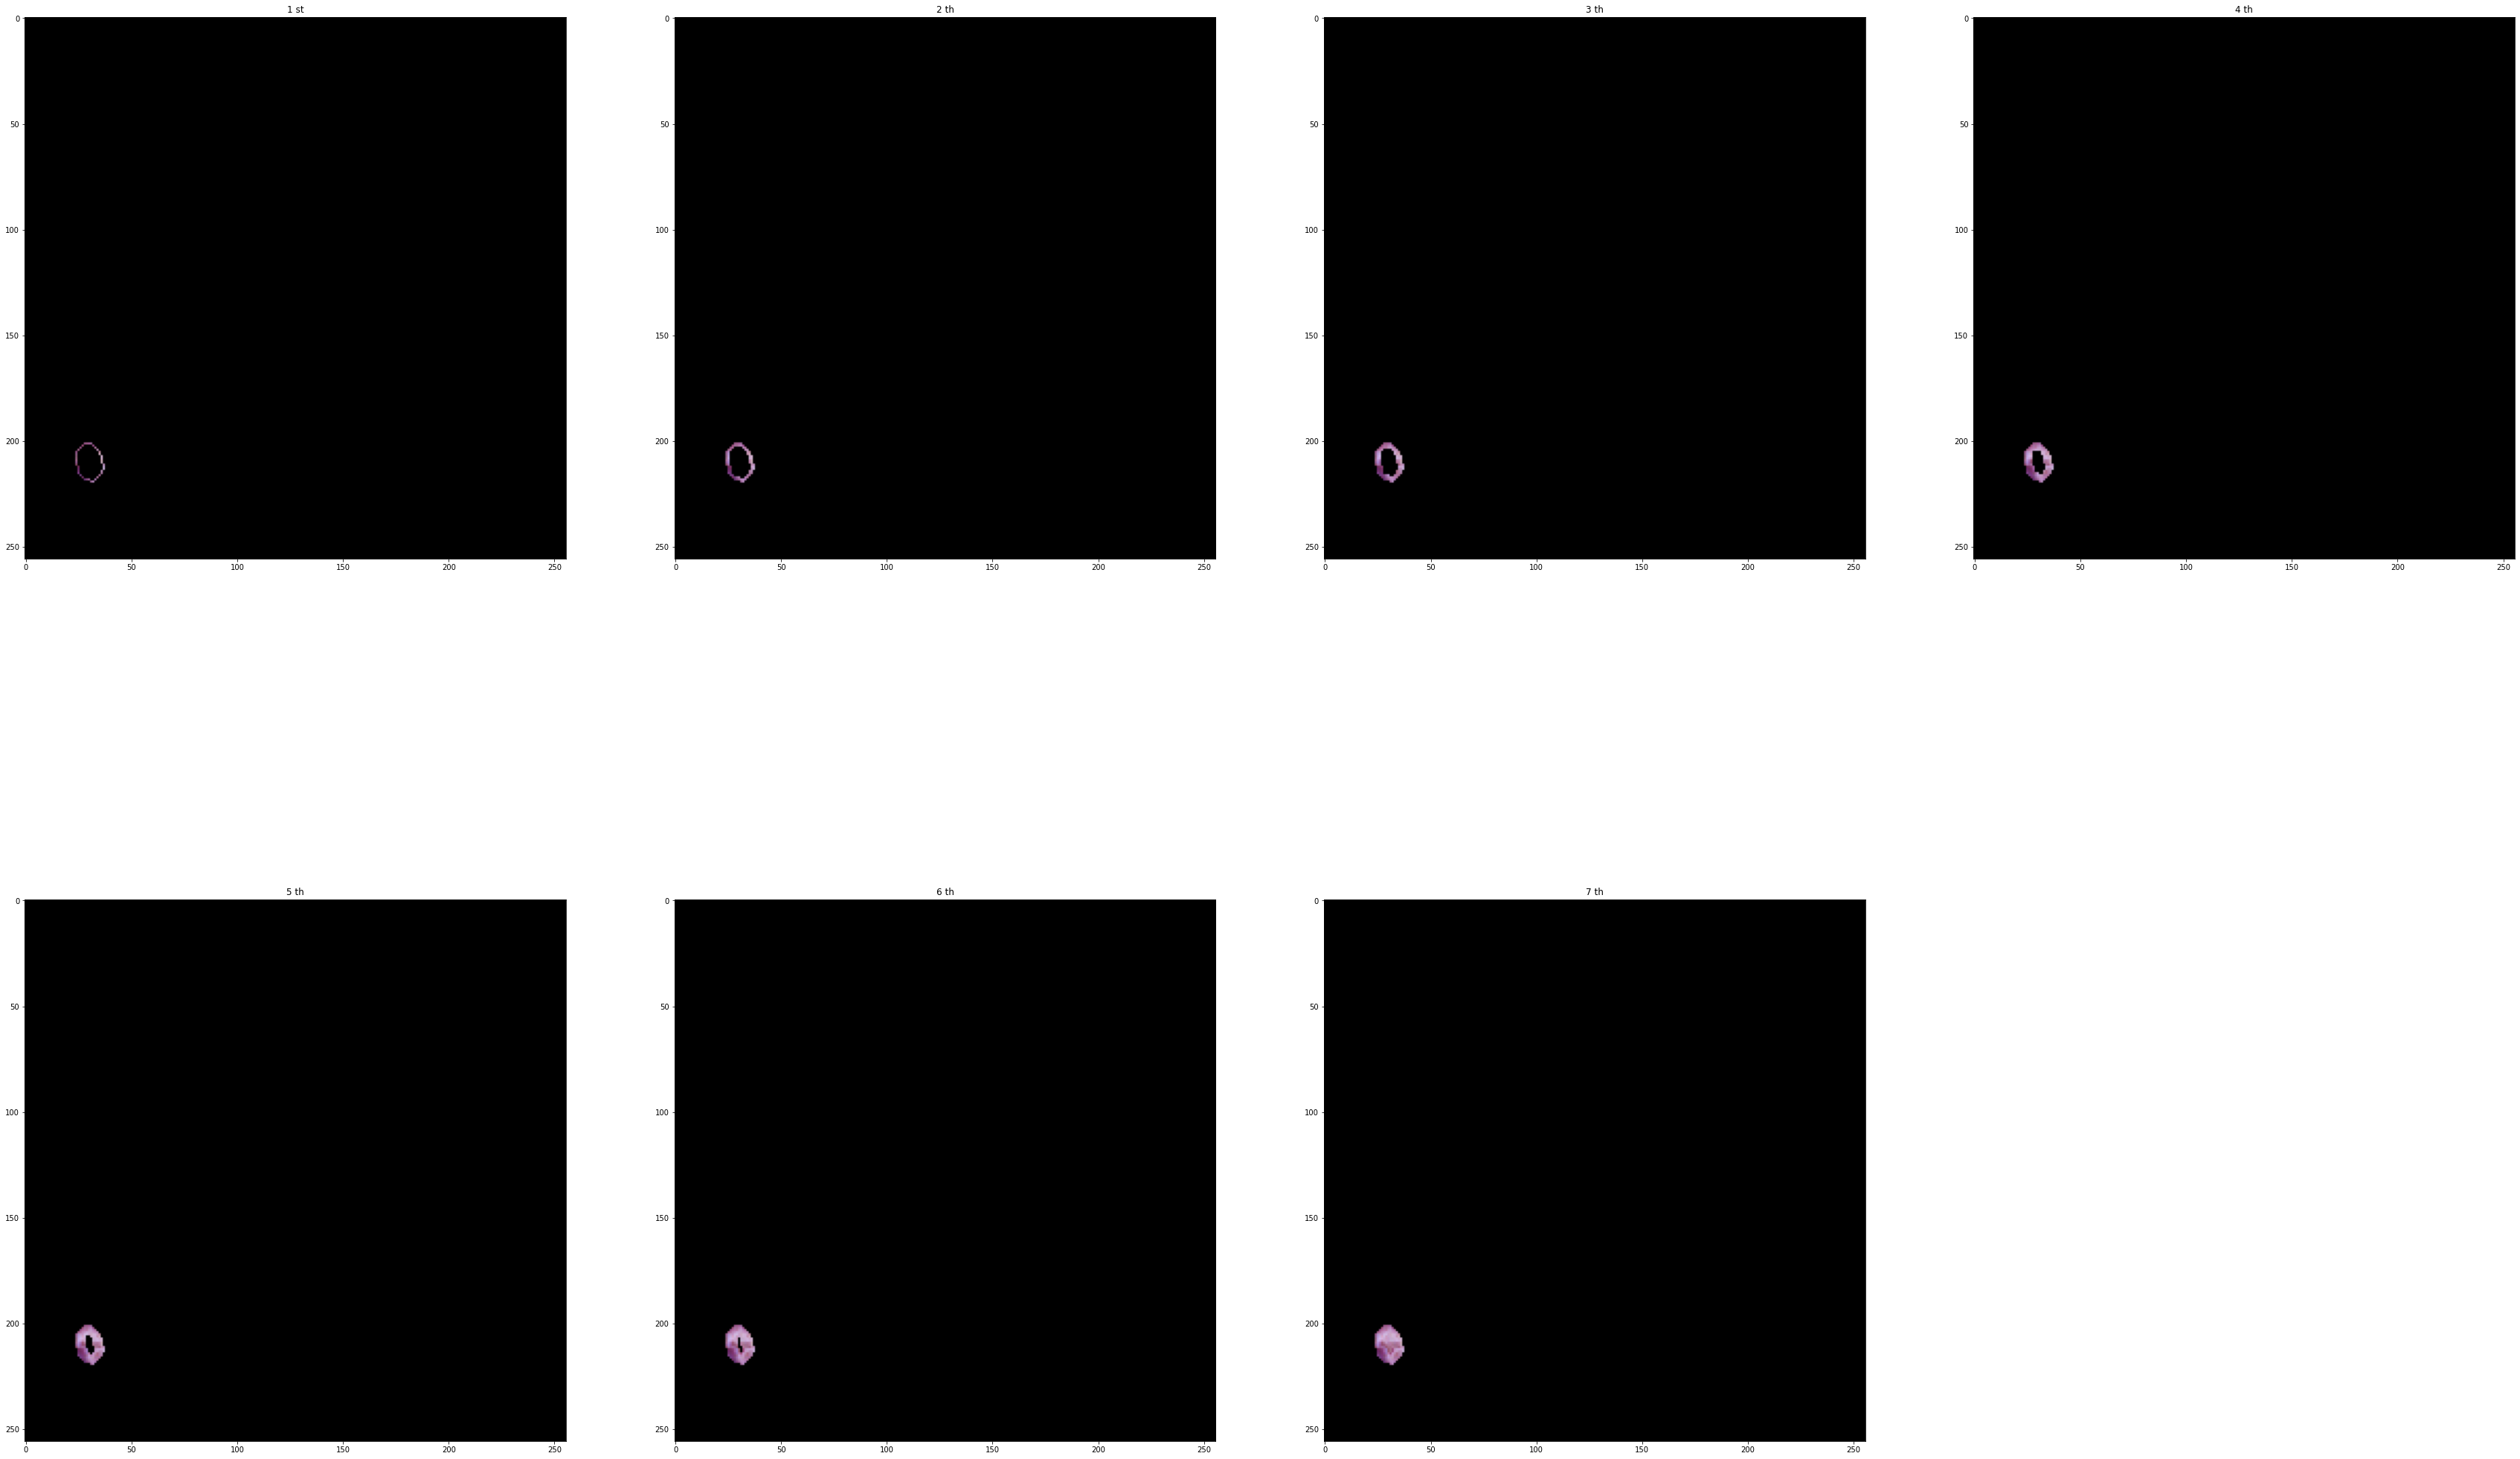

In [442]:
from collections import Counter
from tqdm import tqdm
from PIL import Image

plt.figure(figsize=(60,40))
plt.subplot(len(edges_source_resized)//4+1, 4, 1)
plt.imshow(new)
plt.title('1 st')

T_i_minus_1 = copy.deepcopy(T_1)
edge_source_i_minus_1 = edges_source_resized[0]
edge_target_i_minus_1 = edges_target[0]
edge_idx_i_minus_1_source = np.stack(np.where(edges_source_resized[0]==1),-1) # (length, 2)
edge_idx_i_minus_1_target = np.stack(np.where(edges_target[0]==1),-1)

h_max_t, w_max_t = imsize, imsize
h_max_s, w_max_s = imsize_source, imsize_source

for edge_idx in tqdm(range(1,len(edges_source_resized))):
    edge_source = edges_source_resized[edge_idx]
    edge_target = edges_target[edge_idx]

    edge_idx_source_h, edge_idx_source_w = np.where(edge_source==1)
    edge_idx_target_h, edge_idx_target_w = np.where(edge_target==1)

    T_i = {}
    for idx in range(len(edge_idx_target_h)):
        T_i[f'{edge_idx_target_h[idx]},{edge_idx_target_w[idx]}'] = {'S_coor':[], 'S_represent':[]}
    
    no_represent_key_list = []
    for idx, key in enumerate(T_i.keys()):
        h_target, w_target = map(int, key.split(','))
        mask_target = np.zeros_like(edge_target)
        mask_target[max(0,h_target-1):min(h_target+1+1, h_max_t),
                    max(0,w_target-1):min(w_target+1+1, w_max_t)] = 1
        neighbor_t_i = edge_target_i_minus_1 * mask_target
        neighbor_t_i_idx = np.stack(np.where(neighbor_t_i==1),-1) # T_i 상의 어떤 점 t_j에 대해 T_i-1에 있었던 이웃의 좌표 # T_{i-1}로 올라가고
        
        s_i_minus_1_represents = []
        for h_t, w_t in neighbor_t_i_idx: # T_i-1에 있던 좌표에 대해 # S_{i-1}에 대해
            for represent in T_i_minus_1[f'{h_t},{w_t}']['S_represent']: # S_i로 내려온다
                s_i_minus_1_represents.append(represent)
                h_source, w_source = represent
                mask_source = np.zeros_like(edge_source)
                mask_source[max(0,h_source-1):min(h_source+1+1, h_max_s),
                            max(0,w_source-1):min(w_source+1+1, w_max_s)] = 1
                neighbor_s_i = edge_source * mask_source
                neighbor_s_i_idx = np.stack(np.where(neighbor_s_i==1),-1) # S_i 상의 이웃하는 coordinates # (length, 2)
                T_i[key]['S_coor'] += neighbor_s_i_idx.tolist()

        # 실제 픽셀 값 주기
        if len(T_i[key]['S_coor']) != 0:
            counter = Counter(map(tuple, T_i[key]['S_coor']))
            count_elements = counter.most_common() # [((51, 147), 5), ((52, 147), 5), ... ]
            biggest_num = count_elements[0][1]
            T_i[key]['S_represent'] = [list(item[0]) for item in count_elements if item[1]==biggest_num]
            new[h_target, w_target] = np.sum(np.stack([image_source_resized[item[0], item[1]] for item in T_i[key]['S_represent']], axis=-1), axis=-1)/len(T_i[key]['S_represent'])
        else: # 아래껍질에 짝꿍없는애들
            s_i_minus_1_negihbors = []
            no_represent_key_list.append([h_target, w_target])
            for represent in s_i_minus_1_represents:
                h_source, w_source = represent
                mask_source = np.zeros_like(edge_source)
                mask_source[max(0,h_source-1):min(h_source+1+1, h_max_s),
                            max(0,w_source-1):min(w_source+1+1, w_max_s)] = 1
                neighbor_s_i_minus_1 = edge_source_i_minus_1 * mask_source
                neighbor_s_i_minus_1_idx = np.stack(np.where(neighbor_s_i_minus_1==1),-1).tolist()
                s_i_minus_1_negihbors += neighbor_s_i_minus_1_idx
                new[h_target, w_target] = np.sum(np.stack([image_source_resized[item[0], item[1]] for item in s_i_minus_1_negihbors], axis=-1), axis=-1)/len(s_i_minus_1_negihbors)
    
    # S_represent없는 key 들에게 할당해주기
    while len(no_represent_key_list) != 0:
        if edge_idx+1 == len(edges_source_resized):
            break
        for item in no_represent_key_list:
            h_target, w_target = item
            key = f'{h_target},{w_target}'
            s_represent = []
            negihbors = [f'{int(h_target-1)},{int(w_target-1)}',
                         f'{int(h_target-1)},{int(w_target)}',
                         f'{int(h_target-1)},{int(w_target+1)}',
                         f'{int(h_target)},{int(w_target+1)}',
                         f'{int(h_target)},{int(w_target-1)}',
                         f'{int(h_target+1)},{int(w_target-1)}',
                         f'{int(h_target+1)},{int(w_target)}',
                         f'{int(h_target+1)},{int(w_target+1)}',]
            for neigbor in negihbors:
                try:
                    s_represent += T_i[neigbor]['S_represent']
                except:
                    pass

            if len(s_represent) >= 1:
                T_i[key]['S_represent'] = s_represent
                no_represent_key_list.remove(item)

    # variables for next step
    T_i_minus_1 = T_i
    edge_source_i_minus_1 = edges_source_resized[edge_idx]
    edge_target_i_minus_1 = edges_target[edge_idx]
    edge_idx_i_minus_1_source = np.stack(np.where(edges_source_resized[edge_idx]==1),-1)
    edge_idx_i_minus_1_target = np.stack(np.where(edges_target[edge_idx]==1),-1)

    # plot       
    plt.subplot(len(edges_source_resized)//4+1, 4, edge_idx+1)
    plt.imshow(new)
    plt.title(f'{edge_idx+1} th')

    # save
    save_image = Image.fromarray(new.astype(np.uint8))
    save_image.save(f'./cp_rebirth/{edge_idx}.png')

plt.show()

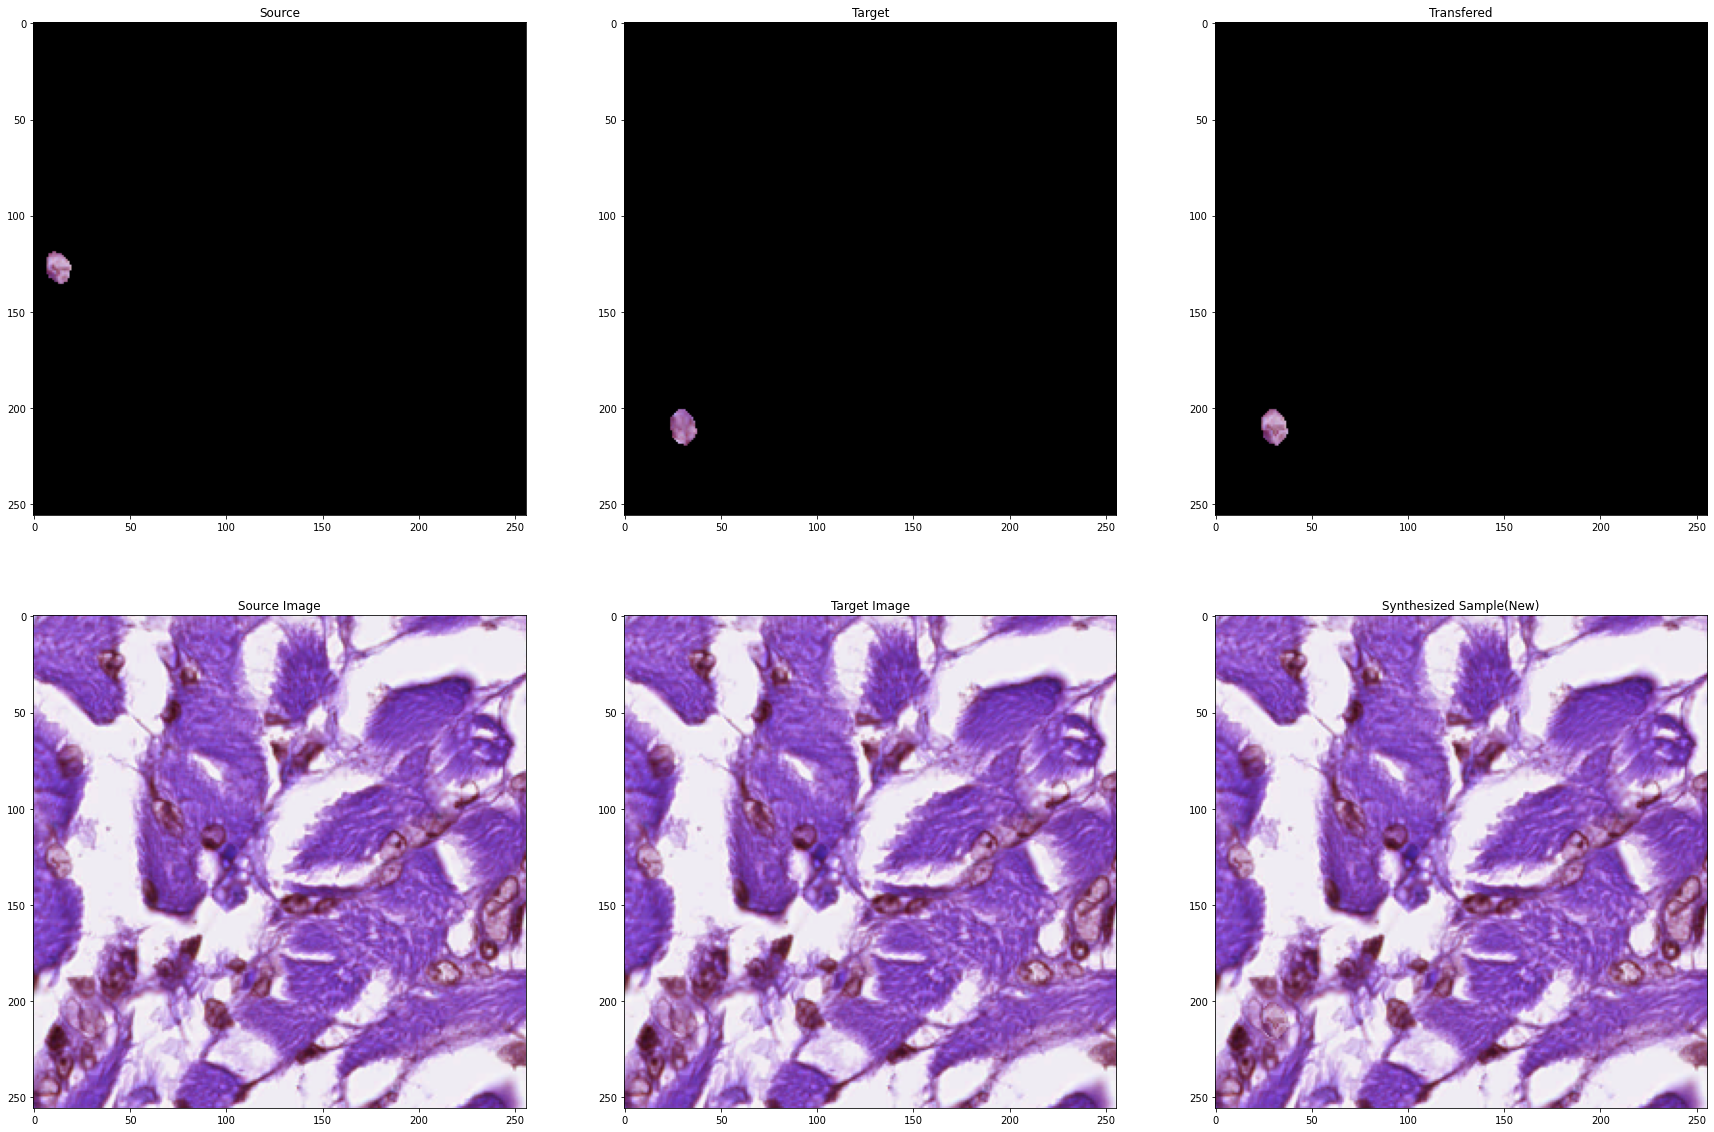

In [443]:
plt.figure(figsize=(30,20))

plt.subplot(2,3,1)
plt.imshow((image_source_resized * selected_source_resized[...,None]).astype(np.uint8))
plt.title('Source')

plt.subplot(2,3,2)
plt.imshow((image_target * selected_target[...,None]).astype(np.uint8))
plt.title('Target')

plt.subplot(2,3,3)
# plt.imshow(cv2.GaussianBlur(new, (0,0), 0.6))
plt.imshow(new)
plt.title('Transfered')

plt.subplot(2,3,4)
plt.imshow(image_source_resized)
plt.title("Source Image")

plt.subplot(2,3,5)
plt.imshow(image_target)
plt.title("Target Image")

plt.subplot(2,3,6)
plt.imshow((image_target*(1-selected_target)[...,None] + new).astype(np.uint8))
plt.title("Synthesized Sample(New)")

plt.show()

# 아래로는 Warping 기반

In [ ]:
_from = []
_to = []

if len(flatten_source_resized) >= len(flatten_target):
    for from_source, to_target in warping_idx:
        _from.append(flatten_source_resized[from_source])
        _to.append(flatten_target[to_target])
else:
    for to_target, from_source in warping_idx:
        _from.append(flatten_source_resized[from_source])
        _to.append(flatten_target[to_target])

_from = np.array(_from) # source 실제 좌표
_to = np.array(_to) # target 실제 좌표

print(len(_from), len(_to))

In [ ]:
def warp(image_source, mask_source, image_target, mask_target, _from, _to):
    '''
    The function warps given images and mask with r=16 of 2D Guassian circle.
    If imsize = 512, there are 16*16=256 circles. (512/(2*r))**2 = 256.

    = input =
    image : np.ndarray. [0, 255]. (h, w, 3) shape
    mask : np.ndarray. [0 or 1]. (h, w) shape

    = return =
    image_warped : np.ndarray. [0, 255]. (h, w, 3) shape
    mask_warped : np.ndarray. [0 or 1]. (h, w) shape
    '''
    # init information
    height, width = image_source.shape[0:2]

    # warping transformations
    transformation_matrix, _ = cv2.findHomography(_from, _to)
    image_warped = cv2.warpPerspective(image, transformation_matrix, (height, width))
    mask_warped = cv2.warpPerspective(mask, transformation_matrix, (height, width))

    # return
    return image_warped, mask_warped

numpy.ndarray

In [ ]:
height, width = image_source.shape[0:2]
transformation_matrix, _ = cv2.findHomography(np.array([[30,10], [30,50], [100, 40], [110, 70]]), np.array([[10,10],[10,100],[100,10],[100,10]]))
image_warped = cv2.warpPerspective(image_source, transformation_matrix, (height, width))
mask_warped = cv2.warpPerspective(selected_source, transformation_matrix, (height, width))

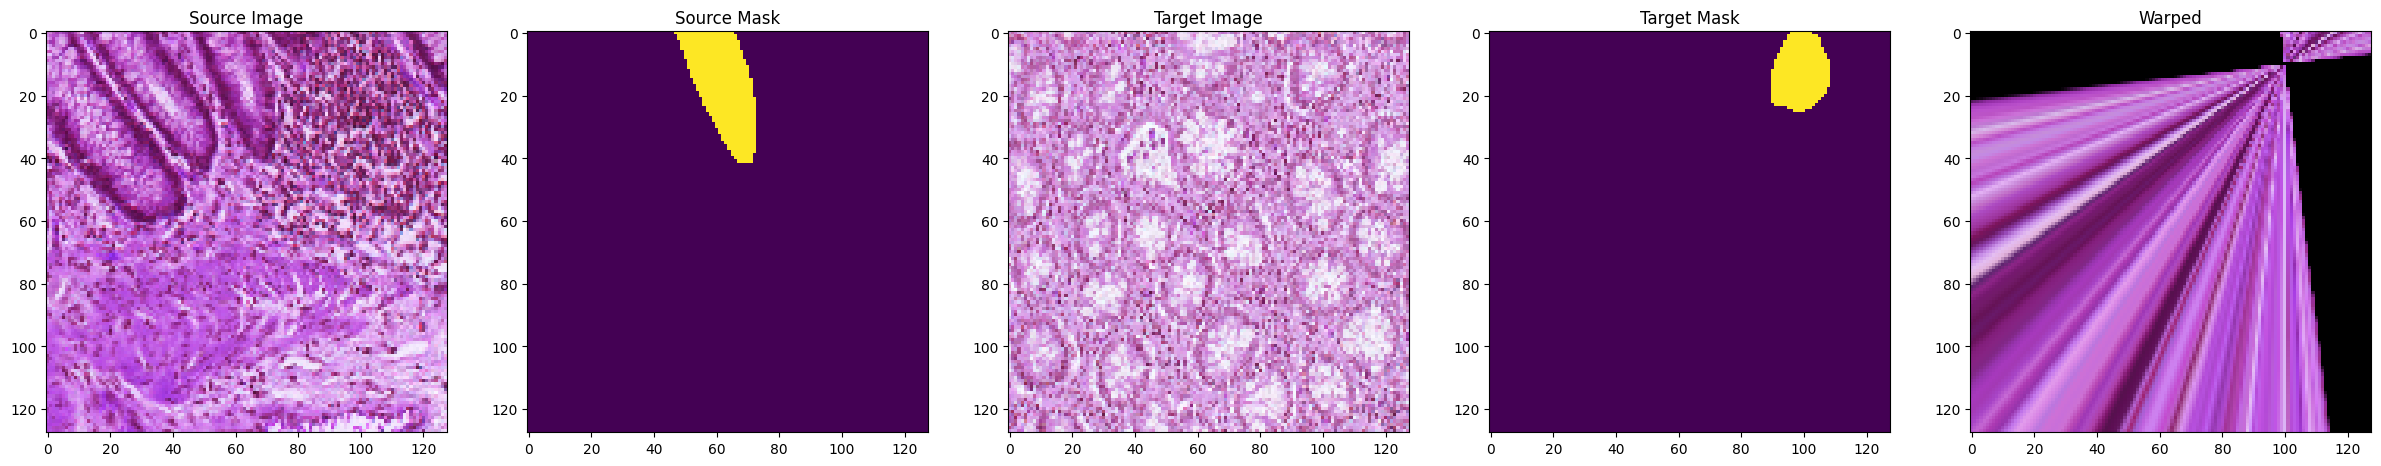

In [ ]:
new_sample = image_target * (1-selected_source)[...,None]
warped = image_warped * (1-mask_warped)[...,None]
new_sample += warped


plt.figure(figsize=(30,20))
plt.subplot(1,5,1)
plt.imshow(image_source)
plt.title('Source Image')

plt.subplot(1,5,2)
plt.imshow(selected_source)
plt.title('Source Mask')

plt.subplot(1,5,3)
plt.imshow(image_target)
plt.title('Target Image')

plt.subplot(1,5,4)
plt.imshow(selected_target)
plt.title('Target Mask')

plt.subplot(1,5,5)
plt.imshow(image_warped)
plt.title('Warped')

plt.show()

In [ ]:
matrix = cv2.getPerspectiveTransform(_from[0:4], _to[0:4])

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:3528: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'
